# Introduction
In this analysis, the goal is to see if there are trends between US politcal affiliations based on the [US 2016 general election](https://www.kaggle.com/paultimothymooney/open-elections-data-usa) and the health of the population. More specifically, we are analyzing [US food desert data](https://www.kaggle.com/tcrammond/food-access-and-food-deserts?select=food_access_variable_lookup.csv) and [US hospital quality](https://www.kaggle.com/abrambeyer/us-hospital-overall-star-ratings-20162020) data. The hospital data is from The Centers for Medicare & Medicaid Services (CMS). The food desert data is from Economic Research Service (ERS) and U.S. Department of Agriculture (USDA). The elections data is from the OpenElections project.

# Set Up

In [1]:
#state and counties cleaning
# winner_county_df['county'] = winner_county_df['county'].str.title()
# winner_county_df['county'] = winner_county_df['county'].str.strip()
# winner_county_df['state'] = winner_county_df['state'].str.strip()
# winner_county_df['county'] = winner_county_df['county'].apply(lambda x: ((str) (x)).replace(' County', ''))

In [2]:
# #geopandas visualization
# countries = gpd.read_file(
#                gpd.datasets.get_path("naturalearth_lowres"))
# base = countries[countries["name"] == "United States of America"].plot(color="gray")
# # winner_county_df.plot(x="lon", y="lat", kind="scatter", c="brightness",
# #         colormap="YlOrRd")
# v = winner_county_joined_df['votes']
# #winner_county_df.plot(figsize=(30,16), ax = base, x="lon", y="lat", kind="scatter", marker='o', c="party_label", colormap="seismic", markersize = (v**2)*5)
# winner_county_joined_df.plot(figsize=(30,16), ax = base, x="lon", y="lat", kind="scatter", marker='.', c="party_label", cmap="seismic", s = v**.4)

In [3]:
!pip install pandasql
!pip install geopandas
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import geopandas as gpd
import datetime as dt
import requests
from lxml import html

from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user


In [6]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('545-final-project').getOrCreate()
%load_ext sparkmagic.magics
import os
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

In [8]:
from sklearn.decomposition import PCA

In [9]:
from sklearn.cluster import KMeans

In [10]:
from yellowbrick.cluster import KElbowVisualizer

# Political Dataset Cleaning and EDA

**Read in dataframes**

In [11]:
president_county_2016_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/20161108__us__general__president__county.csv')
counties_sdf = spark.read.csv('/content/gdrive/My Drive/CIS545Final/US_counties_COVID19_health_weather_data.csv', header=True)
state_abbrv_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/state_to_abbrv.csv')


**Data Cleaning**

In [12]:
president_county_2016_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46159 entries, 0 to 46158
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      46159 non-null  object 
 1   county     46111 non-null  object 
 2   office     46159 non-null  object 
 3   district   0 non-null      float64
 4   party      29546 non-null  object 
 5   candidate  46159 non-null  object 
 6   votes      45947 non-null  float64
dtypes: float64(2), object(5)
memory usage: 2.5+ MB


In [13]:
counties_sdf.printSchema()

root
 |-- date: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- fips: string (nullable = true)
 |-- cases: string (nullable = true)
 |-- deaths: string (nullable = true)
 |-- stay_at_home_announced: string (nullable = true)
 |-- stay_at_home_effective: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- total_population: string (nullable = true)
 |-- area_sqmi: string (nullable = true)
 |-- population_density_per_sqmi: string (nullable = true)
 |-- num_deaths: string (nullable = true)
 |-- years_of_potential_life_lost_rate: string (nullable = true)
 |-- percent_fair_or_poor_health: string (nullable = true)
 |-- average_number_of_physically_unhealthy_days: string (nullable = true)
 |-- average_number_of_mentally_unhealthy_days: string (nullable = true)
 |-- percent_low_birthweight: string (nullable = true)
 |-- percent_smokers: string (nullable = true)
 |-- percent_adults_with_obesit

In [14]:
#drop the office column since the only value is president
#drop district column since all values are null
president_county_2016_df = ps.sqldf("SELECT state, county, party, candidate, votes FROM president_county_2016_df WHERE `party` IS NOT NULL;", globals())
#winner is the candidate with the most votes
winner_county_df = ps.sqldf("SELECT *, MAX(votes) FROM president_county_2016_df GROUP BY `state`, `county` ORDER BY `party`", globals())
nonnull_parties_df = ps.sqldf("SELECT `party` FROM winner_county_df GROUP BY `party`", globals())
states = ps.sqldf("SELECT `state` FROM winner_county_df GROUP BY `state`", globals()) 

**Standardize party values**

In [15]:
winner_county_df = ps.sqldf('''SELECT *, 
CASE
      WHEN party = "D" THEN "D"
      WHEN party = "DEM" THEN "D"
      WHEN party = "DFL" THEN "D"
      WHEN party = "Democrat" THEN "D"
      WHEN party = "Democratic" THEN "D"
      WHEN party = "Democratic Party" THEN "D"
      WHEN party = "Green" THEN "G"
      WHEN party = "LIB" THEN "L"
      WHEN party = "Libertarian" THEN "L"
      WHEN party = "R" THEN "R"
      WHEN party = "REP" THEN "R"
      WHEN party = "Republican" THEN "R"
      WHEN party = "Republican Party" THEN "R"
      ELSE NULL
END
as stand_party
FROM winner_county_df''', globals())
winner_county_df = ps.sqldf('''SELECT *, 
CASE
      WHEN stand_party = "D" THEN 0
      WHEN stand_party = "G" THEN .5
      WHEN stand_party = "L" THEN .5
      WHEN stand_party = "R" THEN 1
      ELSE NULL
END as party_label FROM winner_county_df''', globals())
winner_county_df['county'] = winner_county_df['county'].str.title()
winner_county_df['county'] = winner_county_df['county'].str.strip()
winner_county_df['state'] = winner_county_df['state'].str.strip()
winner_county_df['county'] = winner_county_df['county'].apply(lambda x: ((str) (x)).replace(' County', ''))
winner_county_df['county'] = winner_county_df['county'].apply(lambda x: ((str) (x)).replace(' City', ''))
winner_county_df

,state,county,party,candidate,votes,MAX(votes),stand_party,party_label
0,AL,Bullock,D,Hillary Clinton,3530.0,3530.0,D,0.0
1,AL,Dallas,D,Hillary Clinton,12836.0,12836.0,D,0.0
2,AL,Greene,D,Hillary Clinton,4013.0,4013.0,D,0.0
3,AL,Hale,D,Hillary Clinton,4775.0,4775.0,D,0.0
4,AL,Jefferson,D,Hillary Clinton,156873.0,156873.0,D,0.0
...,...,...,...,...,...,...,...,...
4732,CO,Sedgwick,Republican Party,Donald J. Trump,1015.0,1015.0,R,1.0
4733,CO,Teller,Republican Party,Donald J. Trump,9745.0,9745.0,R,1.0
4734,CO,Washington,Republican Party,Donald J. Trump,2299.0,2299.0,R,1.0
4735,CO,Weld,Republican Party,Donald J. Trump,76651.0,76651.0,R,1.0


**Geographical visualization**

In [16]:
counties_sdf.createOrReplaceTempView('counties')

In [17]:
#Selecting latitude and longitude columns from dataframe
counties_sdf = spark.sql("SELECT county, state, AVG(lat) as lat, AVG(lon) as lon FROM counties GROUP BY county, state ORDER BY county, state")
counties_sdf.show()
counties_df = counties_sdf.toPandas()
counties_df

+---------+--------------+------------------+-------------------+
|   county|         state|               lat|                lon|
+---------+--------------+------------------+-------------------+
|Abbeville|South Carolina| 34.22255586603316| -82.45875420946479|
|   Acadia|     Louisiana| 30.29054537485805| -92.41199324935651|
| Accomack|      Virginia|37.763436337424636| -75.63031843417825|
|      Ada|         Idaho|43.451098422210386|-116.24117375229693|
|    Adair|          Iowa| 41.33075072625035| -94.47097866528796|
|    Adair|      Kentucky|37.104171845286004|  -85.2806370629244|
|    Adair|      Missouri|   40.190594823856| -92.60071538724745|
|    Adair|      Oklahoma|35.883916940863315| -94.65866690851952|
|    Adams|      Colorado|  39.8736347837771|-104.33778193932282|
|    Adams|         Idaho| 44.88959800722434|-116.45383825737521|
|    Adams|      Illinois| 39.98787809506219| -91.18853522130516|
|    Adams|       Indiana|40.745635221281084| -84.93661743200114|
|    Adams

,county,state,lat,lon
0,Abbeville,South Carolina,34.222556,-82.458754
1,Acadia,Louisiana,30.290545,-92.411993
2,Accomack,Virginia,37.763436,-75.630318
3,Ada,Idaho,43.451098,-116.241174
4,Adair,Iowa,41.330751,-94.470979
...,...,...,...,...
3215,Yuma,Arizona,32.769430,-113.905597
3216,Yuma,Colorado,40.002943,-102.424258
3217,Zapata,Texas,27.000780,-99.168655
3218,Zavala,Texas,28.866216,-99.760548


In [18]:
state_abbrv_df

,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA
5,Colorado,Colo.,CO
6,Connecticut,Conn.,CT
7,Delaware,Del.,DE
8,District of Columbia,D.C.,DC
9,Florida,Fla.,FL


In [19]:
#cleaning country and abbreviation values by striping white space and country and city words
counties_df = ps.sqldf("SELECT A.county,	A.state, B.code, A.lat, A.lon FROM counties_df A JOIN state_abbrv_df B ON A.state = B.state ORDER BY A.state, A.county", globals())
counties_df['county'] =  counties_df['county'].str.title()
counties_df['county'] =  counties_df['county'].str.strip()
counties_df['Code'] =  counties_df['Code'].str.strip()
counties_df['county'] = counties_df['county'].apply(lambda x: ((str) (x)).replace(' County', ''))
counties_df['county'] = counties_df['county'].apply(lambda x: ((str) (x)).replace(' City', ''))
counties_df

,county,state,Code,lat,lon
0,Autauga,Alabama,AL,32.534928,-86.642748
1,Baldwin,Alabama,AL,30.727489,-87.722575
2,Barbour,Alabama,AL,31.869589,-85.393213
3,Bibb,Alabama,AL,32.998634,-87.126480
4,Blount,Alabama,AL,33.980878,-86.567383
...,...,...,...,...,...
3132,Sweetwater,Wyoming,WY,41.659538,-108.879567
3133,Teton,Wyoming,WY,43.934776,-110.589759
3134,Uinta,Wyoming,WY,41.287648,-110.547639
3135,Washakie,Wyoming,WY,43.904970,-107.682819


In [20]:
#Join election data and counties data
winner_county_joined_df = ps.sqldf("SELECT B.state, B.Code, A.county, B.lat, B.lon, A.candidate, A.votes, A.stand_party, A.party_label FROM winner_county_df A JOIN counties_df B ON (A.state = B.Code AND A.county = B.county)", globals())

In [21]:
winner_county_joined_df

,state,Code,county,lat,lon,candidate,votes,stand_party,party_label
0,Alabama,AL,Bullock,32.100534,-85.715686,Hillary Clinton,3530.0,D,0.0
1,Alabama,AL,Dallas,32.325976,-87.106472,Hillary Clinton,12836.0,D,0.0
2,Alabama,AL,Greene,32.853157,-87.952213,Hillary Clinton,4013.0,D,0.0
3,Alabama,AL,Hale,32.762670,-87.629151,Hillary Clinton,4775.0,D,0.0
4,Alabama,AL,Jefferson,33.554320,-86.896496,Hillary Clinton,156873.0,D,0.0
...,...,...,...,...,...,...,...,...,...
3091,Colorado,CO,Sedgwick,40.875923,-102.351833,Donald J. Trump,1015.0,R,1.0
3092,Colorado,CO,Teller,38.882158,-105.161794,Donald J. Trump,9745.0,R,1.0
3093,Colorado,CO,Washington,39.971023,-103.201257,Donald J. Trump,2299.0,R,1.0
3094,Colorado,CO,Weld,40.554862,-104.392458,Donald J. Trump,76651.0,R,1.0


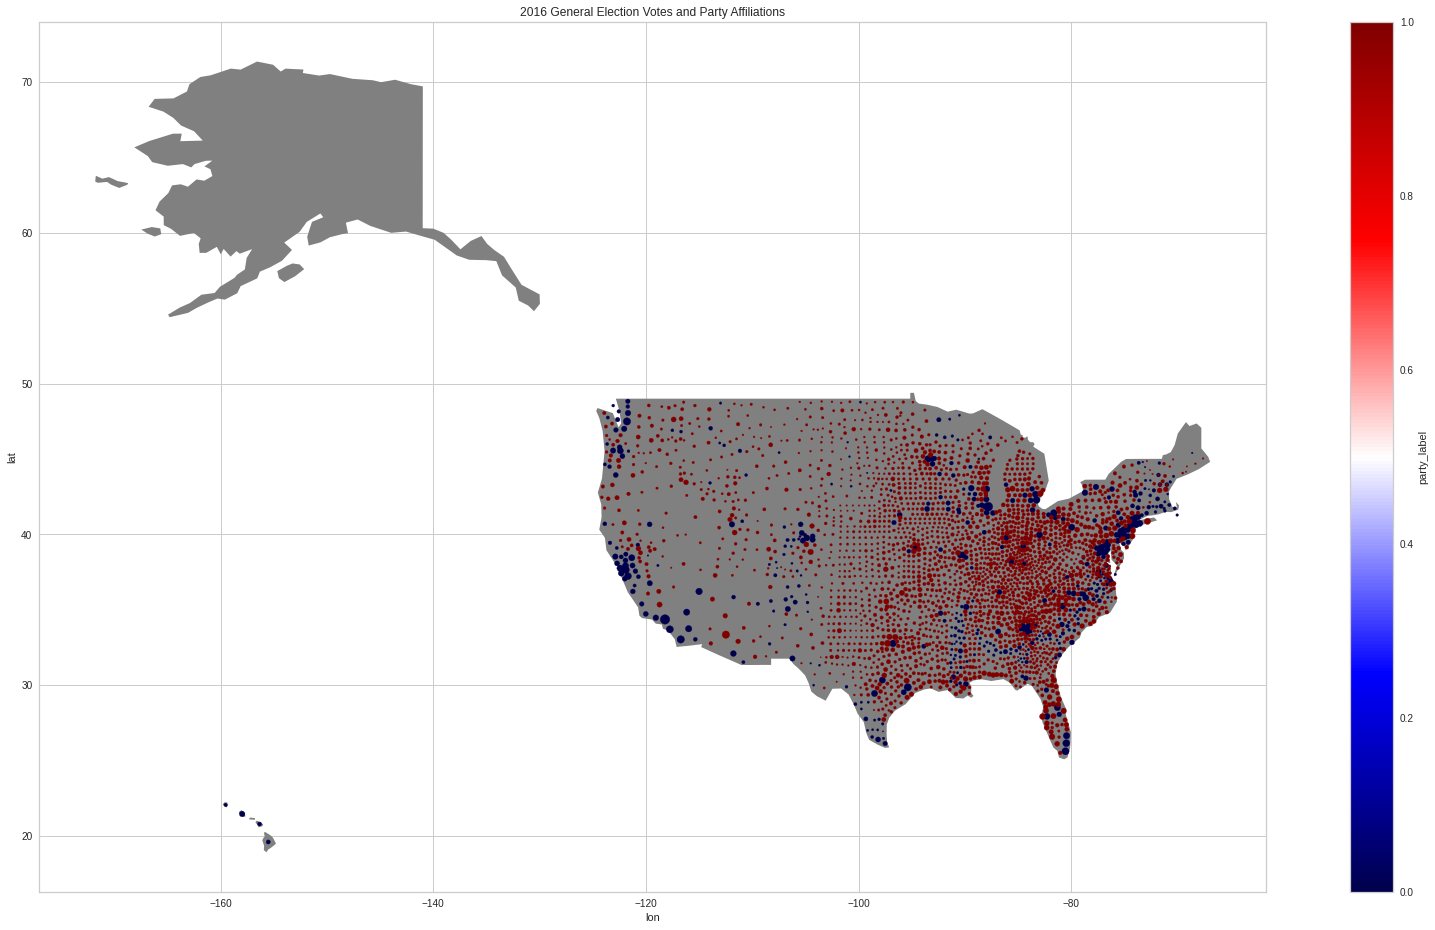

In [22]:
#create geological visualization
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
base = countries[countries["name"] == "United States of America"].plot(color="gray")
v = winner_county_joined_df['votes']
winner_county_joined_df.plot(figsize=(30,16), ax = base, x="lon", y="lat", kind="scatter", marker='.', c="party_label", cmap="seismic", s = v**.4, title="2016 General Election Votes and Party Affiliations")




# Hospital Quality Dataset Cleaning and EDA

In [23]:
# Load dataset (remember to upload dataset first)
hospital_df = pd.read_excel('/content/gdrive/My Drive/CIS545Final/Hospital_General_Information_2016_2020.xlsx')

In [24]:
# Basic info
hospital_df.info

<bound method DataFrame.info of       Facility ID  ...  Year
0          010001  ...  2020
1          010005  ...  2020
2          010006  ...  2020
3          010007  ...  2020
4          010008  ...  2020
...           ...  ...   ...
25077      670114  ...  2016
25078      640001  ...  2016
25079      650001  ...  2016
25080      650003  ...  2016
25081      660001  ...  2016

[25082 rows x 29 columns]>

In [25]:
# Number of NaN values in each column
hospital_df.isna().sum()

Facility ID                                                          0
Facility Name                                                        0
Address                                                              0
City                                                                 0
State                                                                0
ZIP Code                                                             0
County Name                                                         45
Phone Number                                                         0
Hospital Type                                                        0
Hospital Ownership                                                   0
Emergency Services                                                   0
Meets criteria for promoting interoperability of EHRs             3766
Hospital overall rating                                              0
Hospital overall rating footnote                                 17454
Mortal

In [26]:
# States of hospitals with NaN Counties
hospital_df[hospital_df['County Name'].isna()].State

10767    AK
10769    AK
10770    AK
10772    AK
10773    AK
10775    AK
10780    AK
10781    AK
15011    VI
15012    VI
15055    VA
15391    AS
15392    GU
15393    GU
15394    MP
16382    AK
16383    AK
16384    AK
16385    AK
16386    AK
16387    AK
16388    AK
16389    AK
20095    SD
20096    VI
20097    VI
20271    AS
20272    GU
20273    GU
20274    MP
21194    AK
21195    AK
21196    AK
21197    AK
21198    AK
21199    AK
21200    AK
21201    AK
24907    SD
24908    VI
24909    VI
25078    AS
25079    GU
25080    GU
25081    MP
Name: State, dtype: object

Only the columns containing "footnote" have a substantial number of `NaN` values, so those are the columns we'll drop. 

The column containing "EHR" consists of about 15% `NAN` values, so we'll encode the `NAN` values in that column as we would any other value. 

There are only 45 hospitals that have an NaN "County Name", so we'll just drop those rows.

In [27]:
# Drop footnote columns
hospital_df_cleaned = hospital_df.drop(labels=['Hospital overall rating footnote', 'Mortality national comparison footnote', 
                                               'Safety of care national comparison footnote', 'Readmission national comparison footnote', 
                                               'Patient experience national comparison footnote', 'Effectiveness of care national comparison footnote', 
                                               'Timeliness of care national comparison footnote', 'Efficient use of medical imaging national comparison footnote'], axis=1)

In [28]:
# Drop rows with NaN "County Name" values
hospital_df_cleaned.dropna(axis=0, subset=['County Name'], inplace=True)

Now we'll one-hot encode our categorical variables, remembering to replace the "NaN" values in the column containing "EHR" with a string. Note that we'll be treating the "Hospital overall rating" column as categorical, so as not to lose all of the rows with "Not Available" values, since lack of data may also be informative. We'll also change "Y" and "N" in the column containing "EHR" to "Yes" and "No" respectively, to match the "Emergeny Services" column.

In [29]:
# Replace NaN values in EHR column with string 'Not Available'
hospital_df_cleaned['Meets criteria for promoting interoperability of EHRs'].fillna('Not Available', inplace=True)

In [30]:
# Replace 'Y' with 'Yes' and 'N' with 'No' in EHR column
hospital_df_cleaned.replace(to_replace='Y', value='Yes', inplace=True)
hospital_df_cleaned.replace(to_replace='N', value='No', inplace=True)

We'll use the Pandas `get_dummies()` function, since it conveniently produces a one-hot-encoded dataframe with automatically generated column names. This is more expedient than using Scikit-learn's `OneHotEncoder`, which produces a matrix that we'd then have to convert to a dataframe after generating column labels for. Since we're currently only using this for EDA, we don't benefit from the major advantage that `OneHotEncoder` confers, which is that it can be used on later datasets with the same categorical variables. Even when we get to the machine learning portion of the analysis, we'll be splitting this dataset we're currently working with into a train and test set; thus, we don't need to preserve the encodings.

In [31]:
# Get only categorical columns in new dataframe
hospital_df_cleaned_categorical = hospital_df_cleaned.drop(labels=['Facility ID', 'Facility Name', 
                                                                   'Address', 'City', 'State', 
                                                                   'ZIP Code', 'County Name', 
                                                                   'Phone Number', 'Year'], axis=1)
# Convert all columns to type string
hospital_df_cleaned_categorical = hospital_df_cleaned_categorical.astype(str)

Note that we drop the first column of each feature's one hot encoding to avoid redundancy.

In [32]:
# One hot encode dataframe
hospital_df_encoded = pd.get_dummies(data=hospital_df_cleaned_categorical, drop_first=True)

In [33]:
hospital_df_encoded.head(10)

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the National average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the National average,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the National average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the National average,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the National average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the National average,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the National average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the National average,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the National average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the National average,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the National average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the National average,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the National average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the National average,Efficient use of medical imaging national comparison_Same as the national average
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,

Let's now add the state and county (in title case) columns onto our cleaned, encoded data so that we can join it with the food and political datasets.

In [34]:
hospital_df_encoded['State'] = hospital_df_cleaned['State']

In [35]:
hospital_df_encoded['County'] = hospital_df_cleaned['County Name'].apply(lambda x: x.title())
hospital_df_encoded['County'] = hospital_df_encoded['County'].str.strip()
hospital_df_encoded['State'] = hospital_df_encoded['State'].str.strip()
hospital_df_encoded['County'] = hospital_df_encoded['County'].apply(lambda x: ((str) (x)).replace(' County', ''))
hospital_df_encoded['County'] = hospital_df_encoded['County'].apply(lambda x: ((str) (x)).replace(' City', ''))

In [36]:
# Drop duplicate columns with capitalized letter names that get_dummies generates for some reason
hospital_df_encoded.drop(['Mortality national comparison_Below the National average', 
                          "Mortality national comparison_Same as the National average",  
                          "Safety of care national comparison_Below the National average", 
                          "Safety of care national comparison_Same as the National average", 
                          "Readmission national comparison_Below the National average", 
                          "Readmission national comparison_Same as the National average", 
                          "Patient experience national comparison_Below the National average", 
                          "Patient experience national comparison_Same as the National average", 
                          "Effectiveness of care national comparison_Below the National average", 
                          "Effectiveness of care national comparison_Same as the National average", 
                          "Timeliness of care national comparison_Below the National average", 
                          "Timeliness of care national comparison_Same as the National average", 
                          "Efficient use of medical imaging national comparison_Below the National average", 
                          "Efficient use of medical imaging national comparison_Same as the National average"], axis=1, inplace=True)

In [37]:
hospital_df_encoded

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the national average,State,County
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,AL,Houston
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,AL,Marshall
2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,AL,Lauderdale
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,AL,Covington
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,AL,Crenshaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25073,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,TX,Burnet
25074,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Harris
25075,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Ector
25076,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,TX,Bexar


And finally, we'll aggregate the results by summing the values across all of the hospitals in each county and finish by scaling the new dataset.

In [38]:
# Group by state and county and sum values
hospital_encoded_aggregated_df = hospital_df_encoded.groupby(['State', 'County']).sum().reset_index()

In [39]:
hospital_encoded_aggregated_df

,State,County,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the national average
0,AK,Anchorage,15.0,0.0,0.0,4.0,5.0,0.0,0.0,2.0,0.0,7.0,0.0,5.0,0.0,0.0,18.0,14.0,5.0,4.0,5.0,1.0,5.0,0.0,0.0,5.0,12.0,5.0,6.0,5.0,1.0,10.0,1.0,5.0,1.0,0.0,5.0,5.0,7.0,0.0,3.0,5.0,9.0,2.0,7.0,7.0,2.0,2.0,0.0,13.0,4.0
1,AK,Bethel,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0
2,AK,Dillingham,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0
3,AK,Fairbanks North Star,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,6.0,5.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,2.0,4.0,0.0,1.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,4.0
4,AK,Juneau,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2581,WY,Sweetwater,9.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,5.0,2.0,1.0,2.0,0.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,9.0,0.0,3.0,0.0,4.0,1.0,0.0,3.0,4.0,1.0,0.0,0.0,4.0,4.0,0.0,2.0,4

In [40]:
# Save column names as list
hospital_quality_columns = list(hospital_encoded_aggregated_df.drop(labels=['State', 'County'], axis=1))

# Instantiate scaler object
scaler = StandardScaler()

# Scale dataset (without State and County columns) to 0 mean and unit variance
hospital_encoded_aggregated_scaled_array = scaler.fit_transform(hospital_encoded_aggregated_df.drop(labels=['State', 'County'], axis=1))

# Reconstruct dataframe from scaled array and column names
hospital_encoded_aggregated_scaled_df = pd.DataFrame(data=hospital_encoded_aggregated_scaled_array, columns=hospital_quality_columns)

# Add State and County columns back into dataframe
hospital_encoded_aggregated_scaled_df['State'] = hospital_encoded_aggregated_df['State']
hospital_encoded_aggregated_scaled_df['County'] = hospital_encoded_aggregated_df['County']

In [41]:
hospital_encoded_aggregated_scaled_df

,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,Effectiveness of care national comparison_Below the national average,Effectiveness of care national comparison_Not Available,Effectiveness of care national comparison_Same as the national average,Timeliness of care national comparison_Above the national average,Timeliness of care national comparison_Below the national average,Timeliness of care national comparison_Not Available,Timeliness of care national comparison_Same as the national average,Efficient use of medical imaging national comparison_Above the national average,Efficient use of medical imaging national comparison_Below the national average,Efficient use of medical imaging national comparison_Not Available,Efficient use of medical imaging national comparison_Same as the national average,State,County
0,0.597764,-0.154656,-0.817224,2.507788,7.293337,-0.429187,-0.423569,1.527267,-0.106285,0.865805,-0.060691,1.817857,-0.322589,-0.571828,0.749475,0.441067,0.887615,0.276703,0.852083,0.338662,0.465046,-0.159325,-0.380173,0.328830,1.319661,0.784638,1.218600,0.075795,-0.036720,2.129160,-0.157707,0.511385,-0.405029,-0.519423,0.543154,0.423136,1.724089,-0.244634,1.694853,0.514573,0.437692,0.059169,0.889749,0.838037,-0.077585,0.626905,-0.341792,1.177425,0.121871,AK,Anchorage
1,-0.100154,-0.154656,-0.817224,-0.314906,-0.131499,-0.429187,-0.423569,-0.205735,-0.106285,-0.286438,17.774081,-0.267944,-0.322589,-0.571828,-0.292494,-0.246731,-0.341434,0.494727,-0.582292,-0.291849,-0.541826,-0.159325,-0.380173,-0.527864,-0.020273,-0.395330,-0.331982,0.075795,-0.392364,-0.012318,-0.334947,-0.441932,0.018507,-0.519423,0.379219,-0.665433,-0.581915,-0.244634,-0.269101,-0.159078,-0.216380,-0.759072,-0.254485,0.458466,-0.582962,-0.292911,-0.341792,0.125764,-0.570784,AK,Bethel
2,-0.449112,-0.154656,0.754968,-0.314906,-0.131499,-0.429187,-0.423569,-0.205735,-0.106285,-0.286438,-0.060691,-0.267944,-0.322589,0.124577,-0.292494,-0.399575,-0.341434,-0.595392,-0.582292,-0.291849,0.465046,-0.159325,-0.380173,0.328830,-0.690239,-0.395330,-0.331982,0.075795,-0.392364,-0.547688,-0.334947,0.511385,-0.828566,-0.519423,-0.276522,0.423136,-0.581915,-0.244634,-0.269101,0.514573,-0.543416,-0.759072,-0.254485,0.458466,-0.582962,-0.292911,-0.341792,0.125764,-0.570784,AK,Dillingham
3,

In [42]:
# Name file path
shapefile_path = '/content/gdrive/My Drive/CIS545Final/cb_2020_us_county_500k.shx'

In [43]:
# Generate map dataframe
us_county_map_df = gpd.read_file(shapefile_path)

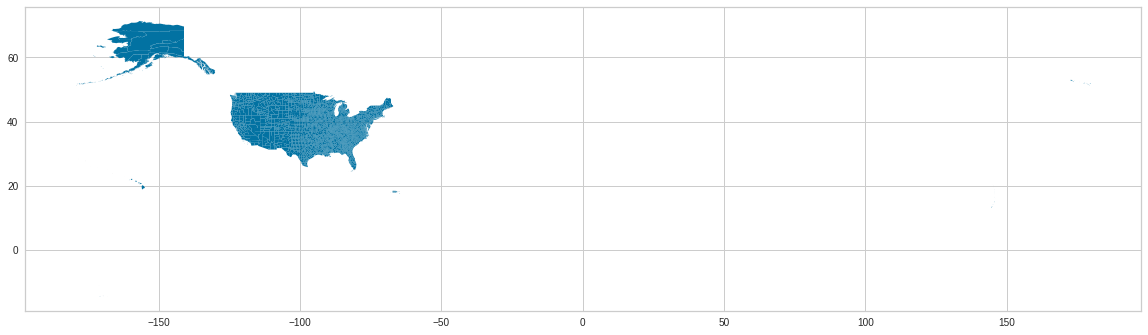

In [44]:
# Visualize US county map
us_county_map_df.plot(figsize=(20, 10))

As we can see, the shapefile includes counties in US territories like Puerto Rico and Guam. However, knowing that the political dataset that we'll be joining the hospital quality dataset to does not have data for the territories (since they don't participate in elections), we'll go ahead and remove these territories from `us_county_map_df` as well.

In [45]:
# Remove counties in territories
us_states_county_map_df = us_county_map_df.copy()
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Puerto Rico'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Guam'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'American Samoa'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Commonwealth of the Northern Mariana Islands'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'United States Virgin Islands'].index, inplace=True)

(-200.0, -50.0)

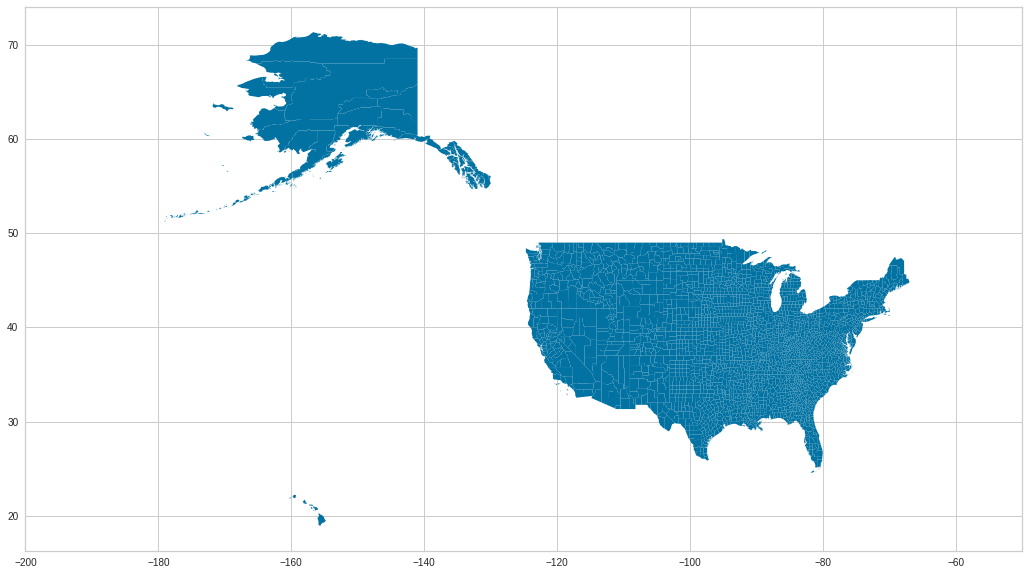

In [46]:
# Visualize US 50 states county map
us_states_county_map_df.plot(figsize=(20, 10))

# Cut off part of Alaska's Aleutian Islands for sake of reasonably sized and scaled visualization
plt.xlim([-200, -50])

Now we'll join this map data with some hospital data so that we can color-code the map accordingly.

In [47]:
# Join hospital_df_cleaned dataframe (with County Name in title case) and us_states_county_map_df dataframe
hospital_df_cleaned['County Name'] = hospital_df_cleaned['County Name'].apply(lambda x: x.title())
us_hospital_map_df = us_states_county_map_df.merge(right=hospital_df_cleaned[['State', 'County Name', 'Hospital overall rating']], how='right', left_on=['STUSPS', 'NAME'], right_on=['State', 'County Name'])

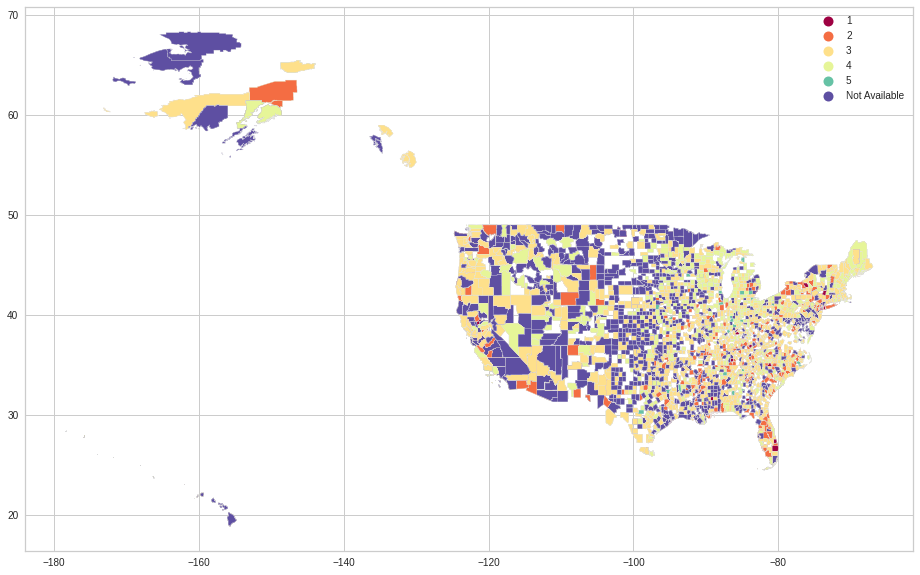

In [48]:
# Visualize merged dataframe, color-coded by 'Hospital overall rating'
fig, ax = plt.subplots(1, figsize=(20,10))
us_hospital_map_df.plot(column='Hospital overall rating', cmap='Spectral', linewidth=0.25, ax=ax, edgecolor='0.9', legend = True)

Hmm. What's probably happening here is that, because many counties have multiple hospitals, but we're not consolidating their reviews in any way, the only reviews we're seeing on the map are the last ones that appear in the dataset for their respective counties, since any previous ones are being overwritten.

To fix this, let's try dropping the "Not Available" rows out of the dataset and converting the 'Hospital overall rating' column to be of a numeric type, so that we can take the average over all hospitals recorded for each county.

In [49]:
# Get state, county, and rating columns from hospital dataset
hospital_df_cleaned_for_viz = hospital_df_cleaned[['State', 'County Name', 'Hospital overall rating']]

In [50]:
# Drop "Not Available" rows
hospital_df_cleaned_for_viz = hospital_df_cleaned_for_viz[hospital_df_cleaned_for_viz['Hospital overall rating'] != "Not Available"]

In [51]:
# Cast 'Hospital Overall Rating' column to be numeric
hospital_df_cleaned_for_viz['Hospital overall rating'] = pd.to_numeric(hospital_df_cleaned_for_viz['Hospital overall rating'])

In [52]:
# Get average hospital rating of each county
hospital_data_to_join = hospital_df_cleaned_for_viz.dropna().groupby(['State', 'County Name']).mean().reset_index()

In [53]:
# Join map dataset with average hospital rating dataset
us_average_hospital_map_df = us_states_county_map_df.merge(right=hospital_data_to_join, how='right', left_on=['STUSPS', 'NAME'], right_on=['State', 'County Name'])

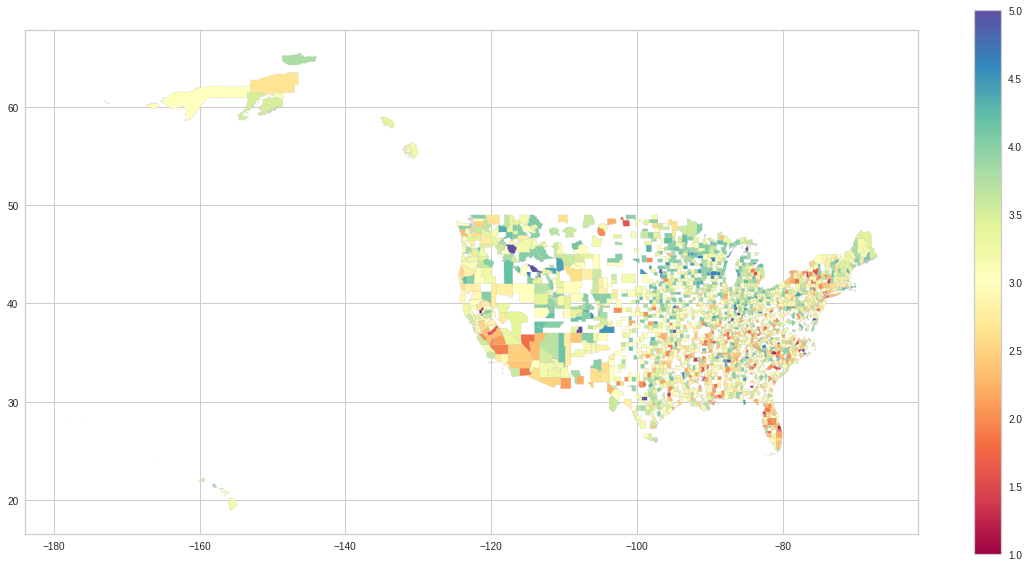

In [54]:
# Visualize merged dataframe, color-coded by 'Hospital overall rating'
fig, ax = plt.subplots(1, figsize=(20,10))
us_average_hospital_map_df.plot(column='Hospital overall rating', cmap='Spectral', linewidth=0.2, ax=ax, edgecolor='0.75', legend = True)

# Food Dataset Cleaning and EDA

In [55]:
#Read in data
food_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/food_access_research_atlas.csv', header=0)
states_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/state_to_abbrv.csv')
food_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Columns: 147 entries, CensusTract to TractSNAP
dtypes: float64(112), int64(33), object(2)
memory usage: 81.7+ MB


In [56]:
states_df 


,State,Abbrev,Code
0,Alabama,Ala.,AL
1,Alaska,Alaska,AK
2,Arizona,Ariz.,AZ
3,Arkansas,Ark.,AR
4,California,Calif.,CA
5,Colorado,Colo.,CO
6,Connecticut,Conn.,CT
7,Delaware,Del.,DE
8,District of Columbia,D.C.,DC
9,Florida,Fla.,FL


In [57]:


food_full_df = pd.read_csv('/content/gdrive/My Drive/CIS545Final/food_access_research_atlas.csv', header=0)
food_full_df['Food Insecurity Percentage'] = food_full_df['LAPOP1_10'] / food_full_df['POP2010']
#food_df.drop(columns=['State', 'County'], axis = 1, inplace=True)
food_full_df['Food Insecurity Percentage']



0        0.709980
1        0.222779
2        0.420360
3        0.310868
4        0.245504
           ...   
72859    0.271169
72860    0.000000
72861    0.061109
72862    0.256337
72863    0.353439
Name: Food Insecurity Percentage, Length: 72864, dtype: float64

In [58]:
#cleaning county and state columns
food_full_df['County'] = food_full_df['County'].str.title()
food_full_df['County'] = food_full_df['County'].str.strip()
food_full_df['State'] = food_full_df['State'].str.title()
food_full_df['State'] = food_full_df['State'].str.strip()
food_full_df['County'] = food_full_df['County'].apply(lambda x: ((str) (x)).replace(' County', ''))
food_full_df['County'] = food_full_df['County'].apply(lambda x: ((str) (x)).replace(' City', ''))
#Join state abbreviations with food data set to set all state values to abbreviations
food_full_df = food_full_df.merge(states_df, how = "left", left_on = 'State',  right_on = 'State')
food_full_df = food_full_df.drop(['State'], axis = 1)
food_full_df = food_full_df.rename(columns = {'Code' : 'State'})


In [59]:
#group by state and county and average the values in all other columns
food_full_df = food_full_df.groupby(['State','County']).mean().reset_index()
#If average greater than 0 replace value with 1 to restore binary values of the following columns
food_full_df['GroupQuartersFlag'] = food_full_df['GroupQuartersFlag'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LILATracts_1And10'] = food_full_df['LILATracts_1And10'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LILATracts_halfAnd10'] = food_full_df['LILATracts_halfAnd10'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LILATracts_1And20'] = food_full_df['LILATracts_1And20'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LILATracts_Vehicle'] = food_full_df['LILATracts_Vehicle'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['HUNVFlag'] = food_full_df['HUNVFlag'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LowIncomeTracts'] = food_full_df['LowIncomeTracts'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LA1and10'] = food_full_df['LA1and10'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LAhalfand10'] = food_full_df['LAhalfand10'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LA1and20'] = food_full_df['LA1and20'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LATracts_half'] = food_full_df['LATracts_half'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LATracts1'] = food_full_df['LATracts1'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LATracts10'] = food_full_df['LATracts10'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LATracts20'] = food_full_df['LATracts20'].apply(lambda x: 1 if x > 0 else 0)
food_full_df['LATractsVehicle_20'] = food_full_df['LATractsVehicle_20'].apply(lambda x: 1 if x > 0 else 0)

food_full_df

,State,County,CensusTract,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,...,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,Food Insecurity Percentage
0,AK,0,2.195420e+09,0.000000,1971.142857,816.857143,0,16.000000,0.006691,1,1,1,1,1,1,17.471429,56230.428571,1,1,1,0,0,1,1,1,639.360213,639.360213,473.211919,256.903864,256.903864,203.449576,1549.712511,0.858231,525.445383,0.395615,361.949000,0.186098,181.230941,0.110976,921.339504,...,0.062957,473.211919,0.377740,203.449576,0.242220,94.148270,0.063633,61.844243,0.059671,259.400555,0.255637,1.950974,0.000995,2.330787,0.001048,0.904258,0.002071,165.328900,0.086731,43.296443,0.031257,14.400930,0.010396,52.650060,0.141740,38.122876,0.045951,672.857143,463.571429,235.142857,1176.428571,6.285714,23.571429,4.285714,574.142857,186.428571,52.714286,127.571429,145.285714,0.463625
1,AK,Aleutians East,2.013000e+09,0.000000,3141.000000,553.000000,0,1726.000000,0.549507,1,1,1,1,1,1,16.400000,63250.000000,1,1,1,0,0,1,1,1,2203.000030,2203.000030,2045.077214,1097.387178,1097.387178,1018.825346,3048.207118,0.970458,1473.436540,0.469098,360.574491,0.114796,151.500529,0.048233,637.980393,...,0.097931,2045.077214,0.651091,1018.825346,0.324363,191.999996,0.061127,92.999999,0.029608,418.863625,0.133354,208.000006,0.066221,784.999992,0.249920,17.000000,0.005412,464.142366,0.147769,152.071183,0.048415,274.000003,0.087233,64.859236,0.117286,44.340431,0.080182,1573.000000,371.000000,155.000000,660.000000,219.000000,1130.000000,19.000000,876.000000,237.000000,385.000000,124.000000,84.000000,0.701369
2,AK,Aleutians West,2.016000e+09,0.000000,2780.500000,606.000000,0,1271.500000,0.427173,1,1,1,1,0,1,11.400000,76654.000000,1,1,1,0,0,1,1,1,598.067371,598.067371,592.500005,231.593239,231.593239,229.983554,2318.140066,0.894342,759.302198,0.315038,350.912551,0.142957,85.271924,0.042562,861.704781,...,0.061546,592.500005,0.500000,229.983554,0.194079,101.999999,0.086076,37.500000,0.031646,144.500002,0.121941,16.000000,0.013502,89.000003,0.075105,3.500000,0.002954,294.499998,0.248523,45.000000,0.037975,30.000000,0.025316,49.761905,0.174603,17.529762,0.061508,890.000000,407.500000,96.500000,1002.000000,166.000000,803.000000,51.500000,428.500000,329.500000,363.000000,88.000000,39.000000,0.501272
3,AK,Anchorage,2.020002e+09,0.945455,5305.927273,1951.490909,0,153.636364,0.033210,1,1,1,1,1,1,8.638182,91073.018182,1,1,1,1,1,0,0,1,1597.668894,3655.839064,1589.106415,289.377366,767.443716,288.186751,3819.101339,0.717523,788.251088,0.152294,993.990801,0.178566,265.408909,0.053082,2620.147861,...,0.000134,0.335611,0.000059,0.055295,0.000010,0.033561,0.000006,0.008390,0.000001,0.276879,0.000048,0.000000,0.000000,0.008390,0.000001,0.000000,0.000000,0.000000,0.000000,0.050342,0.000009,0.000000,0.000000,0.000000,0.000000,0.005260,0.000003,1199.600000,1377.927273,384.345455,3499.963636,295.018182,428.727273,107.290909,420.545455,554.381818,401.109091,114.290909,163.327273,0.298254
4,AK,Bethel,2.050000e+09,0.333333,5671.000000,1550.333333,0,112.666667,0.019754,1,1,1,1,1,1,23.666667,52883.000000,1,1,1,1,1,1,1,1,4587.088856,5079.751592,3842.975319,2594.829334,2721.386922,2077.859236,5265.350587,0.933281,2

In [60]:
food_full_df.columns

Index(['State', 'County', 'CensusTract', 'Urban', 'POP2010', 'OHU2010',
       'GroupQuartersFlag', 'NUMGQTRS', 'PCTGQTRS', 'LILATracts_1And10',
       ...
       'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN',
       'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP',
       'Food Insecurity Percentage'],
      dtype='object', length=148)

Geographical Visualization

In [61]:
# Name file path
shapefile_path = '/content/gdrive/My Drive/CIS545Final/cb_2020_us_county_500k.shx'

In [62]:
# Generate map dataframe
us_county_map_df = gpd.read_file(shapefile_path)
# us_county_map_df

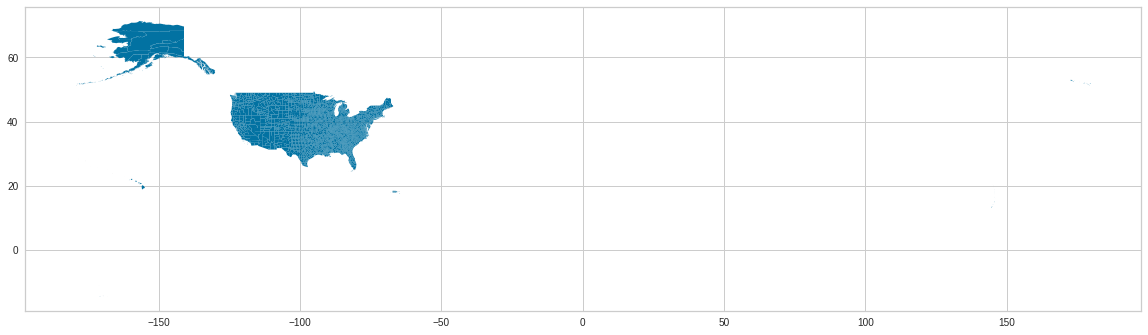

In [63]:
# Visualize US county map
us_county_map_df.plot(figsize=(20, 10) )

In [64]:
# Remove counties in territories

us_states_county_map_df = us_county_map_df.copy()
us_states_county_map_df.head(10)




,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,21,141,00516917,0500000US21141,21141,Logan,Logan County,KY,Kentucky,06,1430224002,12479211,"POLYGON ((-87.06037 36.68085, -87.06002 36.708..."
1,36,081,00974139,0500000US36081,36081,Queens,Queens County,NY,New York,06,281594050,188444349,"POLYGON ((-73.96262 40.73903, -73.96243 40.739..."
2,34,017,00882278,0500000US34017,34017,Hudson,Hudson County,NJ,New Jersey,06,119640822,41836491,"MULTIPOLYGON (((-74.04220 40.69997, -74.03900 ..."
3,34,019,00882228,0500000US34019,34019,Hunterdon,Hunterdon County,NJ,New Jersey,06,1108086284,24761598,"POLYGON ((-75.19511 40.57969, -75.19466 40.581..."
4,21,147,00516926,0500000US21147,21147,McCreary,McCreary County,KY,Kentucky,06,1105416696,10730402,"POLYGON ((-84.77845 36.60329, -84.73068 36.665..."
5,21,195,00516944,0500000US21195,21195,Pike,Pike County,KY,Kentucky,06,2037621882,4756759,"POLYGON ((-82.73269 37.27150, -82.73063 37.273..."
6,21,127,00516910,0500000US21127,21127,Lawrence,Lawrence County,KY,Kentucky,06,1076387821,11582519,"POLYGON ((-83.02497 37.99269, -83.02365 37.993..."
7,36,009,00974103,0500000US36009,36009,Cattaraugus,Cattaraugus County,NY,New York,06,3388125876,36783591,"POLYGON ((-79.05908 42.08673, -79.05908 42.086..."
8,22,109,00559517,0500000US22109,22109,Terrebonne,Terrebonne Parish,LA,Louisiana,15,3185305317,2207679634,"MULTIPOLYGON (((-90.41444 29.20799, -90.41230 ..."
9,22,031,00558521,0500000US22031,22031,De Soto,De Soto Parish,LA,Louisiana,15,2269991655,46990189,"POLYGON ((-94.04268 32.13796, -94.04268 32.137..."


In [65]:
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Puerto Rico'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Guam'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'American Samoa'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'Commonwealth of the Northern Mariana Islands'].index, inplace=True)
us_states_county_map_df.drop(us_county_map_df[us_county_map_df['STATE_NAME'] == 'United States Virgin Islands'].index, inplace=True)


In [66]:
us_states_county_map_df[us_county_map_df['STATE_NAME'] == 'Alaska'].head(3) 


/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1327: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
18,02,050,01419966,0500000US02050,02050,Bethel,Bethel Census Area,AK,Alaska,05,105223804364,12764675306,"MULTIPOLYGON (((-161.67073 58.56075, -161.6672..."
19,02,180,01419977,0500000US02180,02180,Nome,Nome Census Area,AK,Alaska,05,59490634310,13780758093,"MULTIPOLYGON (((-161.31946 64.12363, -161.3183..."
503,02,020,01416061,0500000US02020,02020,Anchorage,Anchorage Municipality,AK,Alaska,12,4420591349,621302197,"MULTIPOLYGON (((-150.07348 61.15834, -150.0691..."


(-200.0, -50.0)

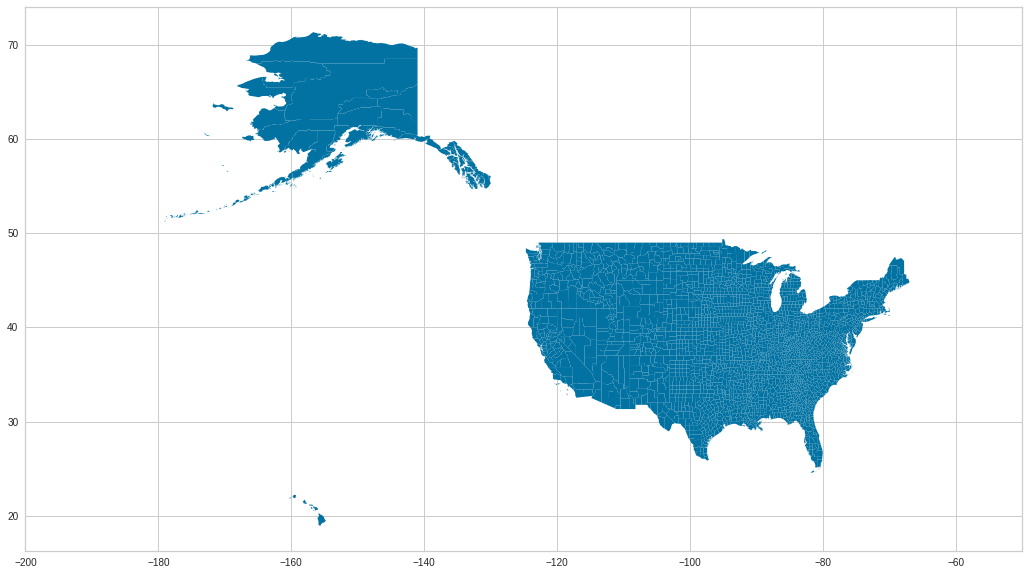

In [67]:
# Visualize US 50 states county map
us_states_county_map_df.plot(figsize=(20, 10))

# Cut off part of Alaska's Aleutian Islands for sake of reasonably sized and scaled visualization
plt.xlim([-200, -50])

In [68]:
# Join food_full_df dataframe (with County Name in title case) and us_states_county_map_df dataframe
food_full_df['County Name'] = food_full_df['County'].apply(lambda x: x.title())
food_map_df = us_states_county_map_df.merge(right=food_full_df[['State', 'County Name', 'Food Insecurity Percentage']], how='right', left_on=['STUSPS', 'NAME'], right_on=['State', 'County Name'])

(-200.0, -50.0)

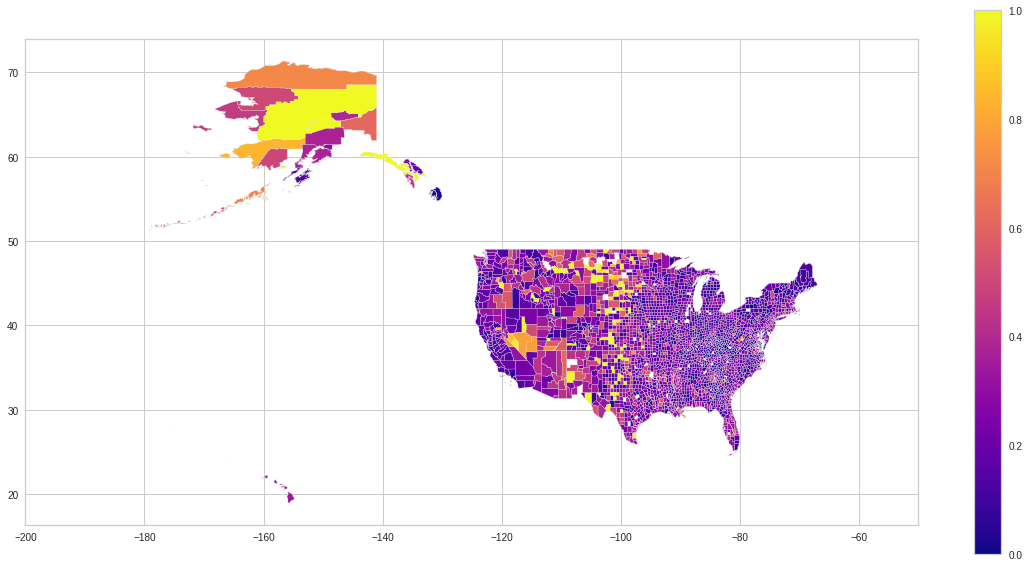

In [69]:
# Visualize merged dataframe, color-coded by 'Hospital overall rating'
fig, ax = plt.subplots(1, figsize=(20,10))
food_map_df.plot(column='Food Insecurity Percentage', cmap='plasma', linewidth=0.25, ax=ax, edgecolor='0.9', legend = True)
plt.xlim([-200, -50])


In [70]:
# Drop "Not Available" rows
hospital_df_cleaned_for_viz = hospital_df_cleaned_for_viz[hospital_df_cleaned_for_viz['Hospital overall rating'] != "Not Available"]

# Join Datasets

In [71]:
hosp_temp = ps.sqldf('''SELECT State, County FROM hospital_encoded_aggregated_scaled_df WHERE State!='AK' GROUP BY State, county ''', globals())
ps.sqldf('''SELECT hos.State, hos.County, food.* FROM food_full_df food JOIN  hosp_temp hos ON hos.State=food.State AND hos.County = food.County WHERE hos.County is NULL AND food.State!="AK"''', globals())

,State,County,State,County,CensusTract,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,...,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,Food Insecurity Percentage,County Name


In [72]:
hospital_encoded_aggregated_scaled_df.State.unique()

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [73]:
hosp_temp

,State,County
0,AL,Autauga
1,AL,Baldwin
2,AL,Barbour
3,AL,Bibb
4,AL,Blount
...,...,...
2561,WY,Sweetwater
2562,WY,Teton
2563,WY,Uinta
2564,WY,Washakie


In [74]:
ps.sqldf('''SELECT State, County FROM hospital_encoded_aggregated_scaled_df WHERE State='WV' GROUP BY State, county ''', globals())

,State,County
0,WV,Barbour
1,WV,Berkeley
2,WV,Boone
3,WV,Braxton
4,WV,Cabell
5,WV,Calhoun
6,WV,Fayette
7,WV,Grant
8,WV,Greenbrier
9,WV,Hampshire


**Joining data**

In [75]:
all_joined_df = ps.sqldf('''SELECT * FROM winner_county_joined_df A JOIN hospital_encoded_aggregated_scaled_df B ON A.Code = B.State AND A.county = B.County''', globals())
all_joined_df = all_joined_df.drop(['State', 'County'], axis=1)
list(all_joined_df.columns)

all_joined_df = ps.sqldf('''SELECT * FROM all_joined_df A JOIN food_full_df B ON A.Code = B.State AND A.county = B.County''', globals())
all_joined_df = all_joined_df.drop(['State', 'County'], axis=1)
all_joined_df = ps.sqldf('''SELECT * FROM all_joined_df GROUP BY Code, county''', globals())

In [76]:
all_joined_df

,state,Code,county,lat,lon,candidate,votes,stand_party,party_label,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,...,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,Food Insecurity Percentage,County Name
0,Alabama,AL,Autauga,32.534928,-86.642748,Donald J. Trump,18172.0,R,1.0,-0.100154,-0.154656,-0.817224,-0.314906,-0.131499,1.596138,-0.423569,-0.205735,-0.106285,-0.286438,-0.060691,-0.267944,-0.322589,-0.571828,-0.292494,-0.246731,-0.341434,-0.377369,0.278333,0.338662,-0.541826,0.370937,-0.380173,-0.527864,-0.355256,-0.159337,-0.331982,-0.856682,0.674569,-0.012318,-0.157707,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1557.666667,1217.750000,545.500000,3571.250000,803.583333,39.500000,2.666667,19.333333,111.250000,109.166667,90.083333,223.500000,0.413022,Autauga
1,Alabama,AL,Baldwin,30.727489,-87.722575,Donald J. Trump,72883.0,R,1.0,0.597764,-0.154656,-0.817224,1.096441,-0.131499,0.380943,-0.423569,-0.205735,-0.106285,0.536593,-0.060691,-0.267944,0.435444,0.542421,0.669324,0.517489,0.641805,1.148799,-0.008542,0.338662,-0.139078,-0.159325,-0.380173,-0.185186,1.319661,0.312650,-0.073552,0.262291,1.385858,0.255367,0.905735,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2041.193548,1351.548387,986.064516,5037.193548,551.774194,43.483871,2.870968,39.225806,204.967742,257.806452,72.322581,208.741935,0.286797,Baldwin
2,Alabama,AL,Barbour,31.869589,-85.393213,Donald J. Trump,5454.0,R,1.0,-0.100154,-0.154656,-0.817224,-0.314906,-0.131499,1.596138,-0.423569,-0.205735,-0.106285,-0.286438,-0.060691,-0.267944,-0.322589,-0.571828,-0.292494,-0.246731,-0.341434,0.276703,-0.295417,-0.291849,-0.541826,-0.159325,-0.380173,-0.527864,-0.020273,-0.395330,-0.331982,0.075795,-0.392364,-0.280003,-0.157707,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

# Dimensionality Reduction

Let's see if PCA works well for the joined dataset. We'll start by scaling the dataset as we've done before.

In [77]:
all_joined_df = all_joined_df.drop(labels=['County Name'], axis=1)

In [78]:
# Save column names as list
all_joined_columns = list(all_joined_df.drop(labels=['state', 'county', 'Code', 'candidate', 'stand_party', 'lat', 'lon'], axis=1))

# Instantiate scaler object
scaler = StandardScaler()

# Scale dataset (without State and County columns) to 0 mean and unit variance
all_joined_scaled_array = scaler.fit_transform(all_joined_df.drop(labels=['state', 'county', 'Code', 'candidate', 'stand_party', 'lat', 'lon'], axis=1))

# Reconstruct dataframe from scaled array and column names
all_joined_scaled_df = pd.DataFrame(data=all_joined_scaled_array, columns=all_joined_columns)

# Add State and County columns back into dataframe
all_joined_scaled_df['State'] = all_joined_df['state']
all_joined_scaled_df['County'] = all_joined_df['county']

In [79]:
# Instantiate a PCA object
pca = PCA()

# Fit the PCA object to the data
pca.fit_transform(all_joined_scaled_df.drop(labels=['State', 'County'], axis=1))

array([[-1.57798382e+00, -1.36221816e+00,  2.92805750e+00, ...,
        -2.15016963e-10,  1.32108800e-14,  1.78692971e-16],
       [ 2.38756989e+00, -2.16796213e+00,  4.64907517e+00, ...,
        -5.50726313e-11,  3.92521914e-14,  8.40368585e-16],
       [-2.42356352e+00, -3.01128392e-01,  1.81465589e+00, ...,
         8.31652599e-10,  3.27830668e-14,  1.07635542e-14],
       ...,
       [-5.49074641e-01, -3.75359648e+00,  2.19647025e+00, ...,
        -3.27123464e-10, -4.27307351e-15,  8.35733439e-16],
       [-6.68032867e-01,  3.05282327e+00, -6.41068832e+00, ...,
         6.14831449e-10,  1.70104018e-15,  1.28431791e-16],
       [-1.48359239e+00,  1.12639886e+00, -4.77442617e+00, ...,
        -7.22862756e-10,  2.05254721e-15, -2.24159893e-16]])

In [80]:
# See percentage of total variance in data captured by each principal component
print(pca.explained_variance_ratio_)

[1.78020836e-01 1.34436545e-01 9.72193578e-02 6.82765479e-02
 4.86195574e-02 4.34704384e-02 4.00518207e-02 3.82839726e-02
 2.69835126e-02 2.20742510e-02 1.62508905e-02 1.44208378e-02
 1.38138273e-02 1.16519459e-02 1.08695528e-02 1.03133723e-02
 9.89390774e-03 9.66567144e-03 8.70992729e-03 8.34452063e-03
 8.33481180e-03 7.97660626e-03 7.32423267e-03 6.47426469e-03
 6.45340648e-03 5.74729351e-03 5.49594943e-03 5.31064840e-03
 5.12784373e-03 5.03852311e-03 4.60993173e-03 4.51801312e-03
 4.28048472e-03 4.15271994e-03 4.09693590e-03 3.87629296e-03
 3.54242712e-03 3.36836648e-03 3.28805343e-03 3.14507260e-03
 3.03893499e-03 3.00838783e-03 2.91124970e-03 2.83809421e-03
 2.80094352e-03 2.72444338e-03 2.69182160e-03 2.66690555e-03
 2.60169779e-03 2.45853050e-03 2.37900023e-03 2.35142485e-03
 2.29822867e-03 2.13353053e-03 2.12616868e-03 1.95638752e-03
 1.88744817e-03 1.88312954e-03 1.68555896e-03 1.64483429e-03
 1.54209428e-03 1.50522691e-03 1.49971871e-03 1.39290480e-03
 1.34494038e-03 1.276937

Text(0.5, 1.0, 'Cumulative Explained Variance')

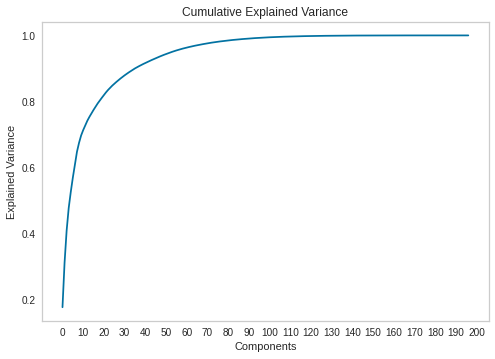

In [81]:
# Plot cumulative explained variance to find elbow
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.xticks(np.arange(0, 203, step=10))
plt.xlabel("Components")
plt.ylabel("Explained Variance")
plt.title("Cumulative Explained Variance")

The PCA hits 95% covered variance in less than half of the total components, so let's transform our data using 95% as our threshold.

In [82]:
# Instantiate a new PCA object to use 95% as its explained variance cutoff for incuding more components
pca_95 = PCA(.95)

# Fit the new PCA object to the data
pca_95.fit(all_joined_scaled_df.drop(labels=['State', 'County', 'party_label'], axis=1))

# Apply the reduction to our data
all_joined_reduced_array = pca_95.transform(all_joined_scaled_df.drop(labels=['State', 'County', 'party_label'], axis=1))

In [83]:
all_joined_reduced_array

array([[-1.55832252, -1.37351289,  2.92664326, ...,  0.01966084,
        -0.52767077,  0.45018803],
       [ 2.43423156, -2.13918711,  4.6989895 , ...,  0.89221179,
         0.79331117, -0.23441673],
       [-2.42211998, -0.32540996,  1.78999104, ...,  0.20728157,
        -0.09628584,  0.69948703],
       ...,
       [-0.49252338, -3.74105968,  2.22229431, ..., -0.08586059,
        -0.13589394,  0.16296968],
       [-0.65090012,  3.07610572, -6.40341982, ...,  0.53081927,
         0.79610395,  0.01129591],
       [-1.45443949,  1.14267077, -4.76679328, ..., -0.27059089,
        -0.39523694,  0.13341575]])

We'll see later on that this dimensinality reduction is able to boost the accuracy of a logistic regression model on our data by over 10%! Let's see what our data looks like when it's projected onto the first two principal components (keeping in mind that the vast majority of the variance is not being captured here).

In [84]:
# Make dataframe from PCA output
all_joined_reduced_df = pd.DataFrame(data=all_joined_reduced_array)

In [85]:
all_joined_scaled_df.head(0)

,votes,party_label,Hospital Type_Acute Care Hospitals,Hospital Type_Childrens,Hospital Type_Critical Access Hospitals,Hospital Type_Psychiatric,Hospital Ownership_Government - Federal,Hospital Ownership_Government - Hospital District or Authority,Hospital Ownership_Government - Local,Hospital Ownership_Government - State,Hospital Ownership_Physician,Hospital Ownership_Proprietary,Hospital Ownership_Tribal,Hospital Ownership_Voluntary non-profit - Church,Hospital Ownership_Voluntary non-profit - Other,Hospital Ownership_Voluntary non-profit - Private,Emergency Services_Yes,Meets criteria for promoting interoperability of EHRs_Yes,Hospital overall rating_2,Hospital overall rating_3,Hospital overall rating_4,Hospital overall rating_5,Hospital overall rating_Not Available,Mortality national comparison_Above the national average,Mortality national comparison_Below the national average,Mortality national comparison_Not Available,Mortality national comparison_Same as the national average,Safety of care national comparison_Above the national average,Safety of care national comparison_Below the national average,Safety of care national comparison_Not Available,Safety of care national comparison_Same as the national average,Readmission national comparison_Above the national average,Readmission national comparison_Below the national average,Readmission national comparison_Not Available,Readmission national comparison_Same as the national average,Patient experience national comparison_Above the national average,Patient experience national comparison_Below the national average,Patient experience national comparison_Not Available,Patient experience national comparison_Same as the national average,Effectiveness of care national comparison_Above the national average,...,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,Food Insecurity Percentage,State,County


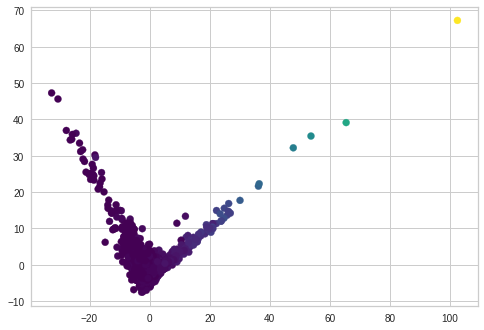

In [86]:
# Make scatter plot on first two principal components
plt.scatter(all_joined_reduced_df[0], all_joined_reduced_df[1], c=all_joined_scaled_df['Hospital Type_Acute Care Hospitals'], cmap='viridis')

Interesting that it takes this shape (that it's not just an indeterminate mass of points), but again, very little of the variance in our dataset is being captured here, so let's do some clustering and color code our scatter plot based on those.

# Clustering

We'll use k-means to cluster the data and see if we can find any natural structure that suggests something about the relationship between our datasets. We'll start by finding the optimal number of clusters using the elbow method.

In [87]:
# Instantiate kmeans and elbow visualizer objects
kmeans_model = KMeans()
distortion_visualizer = KElbowVisualizer(kmeans_model, k=(2, 10), timings=False, locate_elbow=False)

We'll drop the location data so as not to let geographical relationships factor into the analysis. We'll also drop the candidate and stand_party columns, since both of those are effectively encapsulated by the party_label column.

In [88]:
# Drop state, county, Code (state abbreviation), candidate, stand_party, latitude, and longitude columns
all_joined_sans_geo_df = all_joined_df.drop(labels=['state', 'county', 'Code', 'candidate', 'stand_party', 'lat', 'lon'], axis=1)

Now let's see what number of clusters best explains the data.

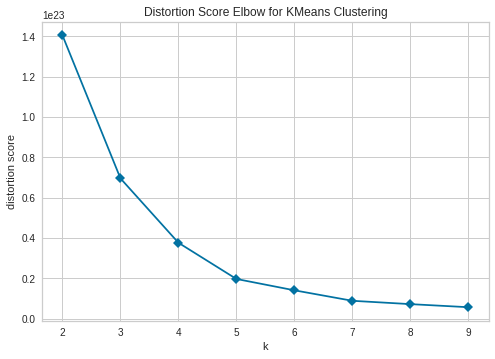

In [89]:
# Fit visualizer to data
distortion_visualizer.fit(all_joined_sans_geo_df)
distortion_visualizer.show()

Ok, so according to the distortion scores, 5 is the best number of clusters to pick. Let's check using the silhouette coefficient as well, and see if it corroborates this.

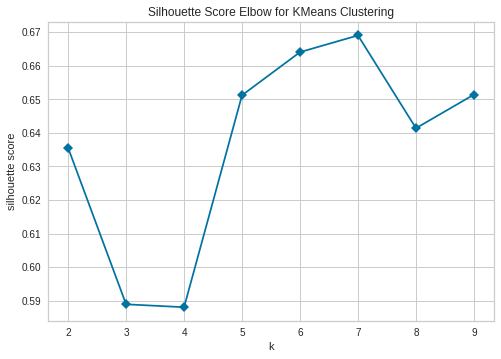

In [90]:
# Instantiate visualizer for silhouette coefficient
silhouette_visualizer = KElbowVisualizer(kmeans_model, k=(2, 10), metric='silhouette', timings=False, locate_elbow=False)

# Fit visualizer to data
silhouette_visualizer.fit(all_joined_sans_geo_df)
silhouette_visualizer.show()

Clearly the silhouette scores indicate that 7 is the best number of clusters to use. And keep in mind, 7 clusters do have a lower distortion than 4 clusters , as we can see from the distortion graph above, so the fact that the silhouette score is obviously peaking at 7 clusters strongly indicates that we should use 7 clusters instead.

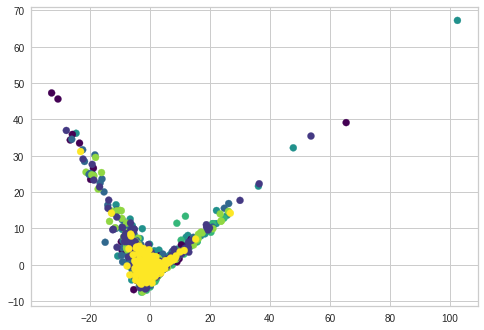

In [91]:
# Instantiate KMeans object to find 7 clusters
kmeans_7 = KMeans(n_clusters=7)

# Fit KMeans object to dataset
clusters = kmeans_7.fit_predict(all_joined_sans_geo_df)

# Color code the PCA by the clusters
plt.scatter(all_joined_reduced_df[0], all_joined_reduced_df[1], c=clusters, cmap='viridis')

So that's not really informative at all, which is unfortunate but not at all unsurprising, given how little variance the first two principal components encompass. Let's try it with 4 clusters instead to see if that's any more intuitive.

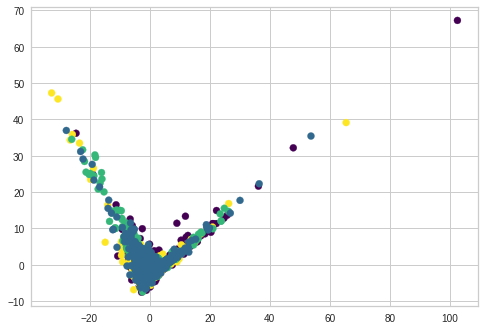

In [92]:
# Instantiate KMeans object to find 4 clusters
kmeans_4 = KMeans(n_clusters=4)

# Fit KMeans object to dataset
clusters_4 = kmeans_4.fit_predict(all_joined_sans_geo_df)

# Color code the PCA by the clusters
plt.scatter(all_joined_reduced_df[0], all_joined_reduced_df[1], c=clusters_4, cmap='viridis')

Well, that's the way it goes sometimes. It's good that we tried this to see if we could get any insight before going into model training, but PCA just doesn't capture enough of the variance in our dataset in the first two components for us to get a human-interpretable visualization out of this.

On to supervised learning!

#Modeling

Logistic Regression without PCA

In [93]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
X = all_joined_df.drop(labels=['state',	'Code',	'county',	'lat', 'lon', 'candidate',	'votes', 'stand_party'], axis=1)

y = all_joined_df['party_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=10000)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 83.6%


Logistic Regression with PCA

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
X = all_joined_reduced_array
y = all_joined_df['party_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=10000)
# clf.fit(X_train,y_train)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)

accuracy = sklearn.metrics.accuracy_score(prediction,y_test)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 94.3%


Neural Network with PCA

In [95]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1)

params = { 
    'hidden_layer_sizes': [(50,50,50), (100,50,50), (100,100,100)],
    'activation' : ['logistic', 'tanh', 'relu'],
    'learning_rate_init': [.001, .0001]
    }

mlp_cv = GridSearchCV(mlp, params, scoring='accuracy',
                      cv=5)
mlp_cv.fit(X_train, y_train)
print('best_params: {}\n'.format(mlp_cv.best_params_))


Iteration 1, loss = 0.62163354
Iteration 2, loss = 0.57660397
Iteration 3, loss = 0.53032507
Iteration 4, loss = 0.49726809
Iteration 5, loss = 0.47540795
Iteration 6, loss = 0.46241154
Iteration 7, loss = 0.45464466
Iteration 8, loss = 0.45005381
Iteration 9, loss = 0.44754118
Iteration 10, loss = 0.44578982
Iteration 11, loss = 0.44473285
Iteration 12, loss = 0.44418276
Iteration 13, loss = 0.44377608
Iteration 14, loss = 0.44346328
Iteration 15, loss = 0.44330864
Iteration 16, loss = 0.44318811
Iteration 17, loss = 0.44309048
Iteration 18, loss = 0.44307549
Iteration 19, loss = 0.44300512
Iteration 20, loss = 0.44298904
Iteration 21, loss = 0.44296761
Iteration 22, loss = 0.44294909
Iteration 23, loss = 0.44295044
Iteration 24, loss = 0.44293328
Iteration 25, loss = 0.44293685
Iteration 26, loss = 0.44293498
Iteration 27, loss = 0.44292079
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.62165286
Iteration 2, loss = 0.57

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.58279762
Iteration 9, loss = 0.57636242
Iteration 10, loss = 0.57007962
Iteration 11, loss = 0.56415188
Iteration 12, loss = 0.55863314
Iteration 13, loss = 0.55340048
Iteration 14, loss = 0.54833957
Iteration 15, loss = 0.54357299
Iteration 16, loss = 0.53905588
Iteration 17, loss = 0.53476144
Iteration 18, loss = 0.53075692
Iteration 19, loss = 0.52674365
Iteration 20, loss = 0.52315280
Iteration 21, loss = 0.51960081
Iteration 22, loss = 0.51631070
Iteration 23, loss = 0.51321385
Iteration 24, loss = 0.51012721
Iteration 25, loss = 0.50724662
Iteration 26, loss = 0.50455378
Iteration 27, loss = 0.50194972
Iteration 28, loss = 0.49942626
Iteration 29, loss = 0.49709276
Iteration 30, loss = 0.49490120
Iteration 31, loss = 0.49269790
Iteration 32, loss = 0.49067176
Iteration 33, loss = 0.48876032
Iteration 34, loss = 0.48686091
Iteration 35, loss = 0.48510552
Iteration 36, loss = 0.48342386
Iteration 37, loss = 0.48179334
Iteration 38, loss = 0.48022932
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.62038203
Iteration 4, loss = 0.61257246
Iteration 5, loss = 0.60470581
Iteration 6, loss = 0.59729407
Iteration 7, loss = 0.58996000
Iteration 8, loss = 0.58315100
Iteration 9, loss = 0.57656798
Iteration 10, loss = 0.57040690
Iteration 11, loss = 0.56446057
Iteration 12, loss = 0.55908131
Iteration 13, loss = 0.55367373
Iteration 14, loss = 0.54866808
Iteration 15, loss = 0.54397494
Iteration 16, loss = 0.53952388
Iteration 17, loss = 0.53518477
Iteration 18, loss = 0.53108521
Iteration 19, loss = 0.52734144
Iteration 20, loss = 0.52361385
Iteration 21, loss = 0.52015912
Iteration 22, loss = 0.51680577
Iteration 23, loss = 0.51366593
Iteration 24, loss = 0.51069754
Iteration 25, loss = 0.50782367
Iteration 26, loss = 0.50512458
Iteration 27, loss = 0.50252105
Iteration 28, loss = 0.50008920
Iteration 29, loss = 0.49769198
Iteration 30, loss = 0.49550708
Iteration 31, loss = 0.49335201
Iteration 32, loss = 0.49128853
Iteration 33, loss = 0.48943665
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.59728281
Iteration 7, loss = 0.59001999
Iteration 8, loss = 0.58309746
Iteration 9, loss = 0.57660345
Iteration 10, loss = 0.57043301
Iteration 11, loss = 0.56449573
Iteration 12, loss = 0.55905247
Iteration 13, loss = 0.55375303
Iteration 14, loss = 0.54873931
Iteration 15, loss = 0.54406823
Iteration 16, loss = 0.53950178
Iteration 17, loss = 0.53529600
Iteration 18, loss = 0.53119081
Iteration 19, loss = 0.52738107
Iteration 20, loss = 0.52371132
Iteration 21, loss = 0.52016810
Iteration 22, loss = 0.51692456
Iteration 23, loss = 0.51372374
Iteration 24, loss = 0.51075847
Iteration 25, loss = 0.50789097
Iteration 26, loss = 0.50513290
Iteration 27, loss = 0.50264120
Iteration 28, loss = 0.50010332
Iteration 29, loss = 0.49778624
Iteration 30, loss = 0.49555218
Iteration 31, loss = 0.49341269
Iteration 32, loss = 0.49133421
Iteration 33, loss = 0.48946035
Iteration 34, loss = 0.48755960
Iteration 35, loss = 0.48583705
Iteration 36, loss = 0.48413093
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 9, loss = 0.57658716
Iteration 10, loss = 0.57042263
Iteration 11, loss = 0.56452136
Iteration 12, loss = 0.55905465
Iteration 13, loss = 0.55375754
Iteration 14, loss = 0.54871564
Iteration 15, loss = 0.54405600
Iteration 16, loss = 0.53952558
Iteration 17, loss = 0.53527975
Iteration 18, loss = 0.53120943
Iteration 19, loss = 0.52734661
Iteration 20, loss = 0.52374155
Iteration 21, loss = 0.52018002
Iteration 22, loss = 0.51692015
Iteration 23, loss = 0.51376026
Iteration 24, loss = 0.51074265
Iteration 25, loss = 0.50796725
Iteration 26, loss = 0.50515713
Iteration 27, loss = 0.50265820
Iteration 28, loss = 0.50012752
Iteration 29, loss = 0.49780167
Iteration 30, loss = 0.49560387
Iteration 31, loss = 0.49345995
Iteration 32, loss = 0.49137348
Iteration 33, loss = 0.48949118
Iteration 34, loss = 0.48758868
Iteration 35, loss = 0.48591234
Iteration 36, loss = 0.48414258
Iteration 37, loss = 0.48253435
Iteration 38, loss = 0.48101696
Iteration 39, loss = 0.47946467
Iteration

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.46185437
Iteration 6, loss = 0.45380623
Iteration 7, loss = 0.44978713
Iteration 8, loss = 0.44698089
Iteration 9, loss = 0.44549541
Iteration 10, loss = 0.44459770
Iteration 11, loss = 0.44392273
Iteration 12, loss = 0.44357598
Iteration 13, loss = 0.44338508
Iteration 14, loss = 0.44322093
Iteration 15, loss = 0.44312391
Iteration 16, loss = 0.44304794
Iteration 17, loss = 0.44301322
Iteration 18, loss = 0.44308892
Iteration 19, loss = 0.44295622
Iteration 20, loss = 0.44295495
Iteration 21, loss = 0.44294703
Iteration 22, loss = 0.44293204
Iteration 23, loss = 0.44294981
Iteration 24, loss = 0.44291806
Iteration 25, loss = 0.44292496
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.54219521
Iteration 2, loss = 0.51781574
Iteration 3, loss = 0.49217665
Iteration 4, loss = 0.47361054
Iteration 5, loss = 0.46185623
Iteration 6, loss = 0.45377646
Iteration 7, loss = 0.44984506
Iteration 8, loss = 0.4470

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.53300083
Iteration 6, loss = 0.52876461
Iteration 7, loss = 0.52494944
Iteration 8, loss = 0.52113573
Iteration 9, loss = 0.51759553
Iteration 10, loss = 0.51417785
Iteration 11, loss = 0.51098379
Iteration 12, loss = 0.50793037
Iteration 13, loss = 0.50505606
Iteration 14, loss = 0.50221104
Iteration 15, loss = 0.49964773
Iteration 16, loss = 0.49713781
Iteration 17, loss = 0.49478771
Iteration 18, loss = 0.49261646
Iteration 19, loss = 0.49041083
Iteration 20, loss = 0.48837828
Iteration 21, loss = 0.48642419
Iteration 22, loss = 0.48459064
Iteration 23, loss = 0.48287807
Iteration 24, loss = 0.48115091
Iteration 25, loss = 0.47956794
Iteration 26, loss = 0.47805553
Iteration 27, loss = 0.47660461
Iteration 28, loss = 0.47520967
Iteration 29, loss = 0.47387150
Iteration 30, loss = 0.47261337
Iteration 31, loss = 0.47143486
Iteration 32, loss = 0.47023126
Iteration 33, loss = 0.46914453
Iteration 34, loss = 0.46810902
Iteration 35, loss = 0.46710683
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 7, loss = 0.52536347
Iteration 8, loss = 0.52152724
Iteration 9, loss = 0.51799351
Iteration 10, loss = 0.51466847
Iteration 11, loss = 0.51150115
Iteration 12, loss = 0.50843958
Iteration 13, loss = 0.50556931
Iteration 14, loss = 0.50286696
Iteration 15, loss = 0.50021949
Iteration 16, loss = 0.49772584
Iteration 17, loss = 0.49542101
Iteration 18, loss = 0.49314187
Iteration 19, loss = 0.49100389
Iteration 20, loss = 0.48899874
Iteration 21, loss = 0.48706869
Iteration 22, loss = 0.48527402
Iteration 23, loss = 0.48350142
Iteration 24, loss = 0.48180369
Iteration 25, loss = 0.48025112
Iteration 26, loss = 0.47870201
Iteration 27, loss = 0.47728241
Iteration 28, loss = 0.47593347
Iteration 29, loss = 0.47461281
Iteration 30, loss = 0.47333544
Iteration 31, loss = 0.47210975
Iteration 32, loss = 0.47097101
Iteration 33, loss = 0.46994902
Iteration 34, loss = 0.46886336
Iteration 35, loss = 0.46782178
Iteration 36, loss = 0.46688818
Iteration 37, loss = 0.46595760
Iteration 3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.53330375
Iteration 6, loss = 0.52921428
Iteration 7, loss = 0.52539283
Iteration 8, loss = 0.52153467
Iteration 9, loss = 0.51799464
Iteration 10, loss = 0.51464692
Iteration 11, loss = 0.51150267
Iteration 12, loss = 0.50842090
Iteration 13, loss = 0.50557336
Iteration 14, loss = 0.50288758
Iteration 15, loss = 0.50019403
Iteration 16, loss = 0.49774761
Iteration 17, loss = 0.49537374
Iteration 18, loss = 0.49315870
Iteration 19, loss = 0.49101796
Iteration 20, loss = 0.48903338
Iteration 21, loss = 0.48709070
Iteration 22, loss = 0.48527935
Iteration 23, loss = 0.48352682
Iteration 24, loss = 0.48182484
Iteration 25, loss = 0.48025855
Iteration 26, loss = 0.47871518
Iteration 27, loss = 0.47729102
Iteration 28, loss = 0.47594958
Iteration 29, loss = 0.47460359
Iteration 30, loss = 0.47335433
Iteration 31, loss = 0.47210504
Iteration 32, loss = 0.47099304
Iteration 33, loss = 0.46996988
Iteration 34, loss = 0.46885339
Iteration 35, loss = 0.46782084
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.53328959
Iteration 6, loss = 0.52920512
Iteration 7, loss = 0.52542042
Iteration 8, loss = 0.52157628
Iteration 9, loss = 0.51798383
Iteration 10, loss = 0.51468455
Iteration 11, loss = 0.51154896
Iteration 12, loss = 0.50847004
Iteration 13, loss = 0.50558096
Iteration 14, loss = 0.50292173
Iteration 15, loss = 0.50018104
Iteration 16, loss = 0.49782054
Iteration 17, loss = 0.49536930
Iteration 18, loss = 0.49316503
Iteration 19, loss = 0.49104683
Iteration 20, loss = 0.48902024
Iteration 21, loss = 0.48710164
Iteration 22, loss = 0.48526054
Iteration 23, loss = 0.48352024
Iteration 24, loss = 0.48182738
Iteration 25, loss = 0.48027641
Iteration 26, loss = 0.47873947
Iteration 27, loss = 0.47729440
Iteration 28, loss = 0.47595587
Iteration 29, loss = 0.47460335
Iteration 30, loss = 0.47336285
Iteration 31, loss = 0.47210034
Iteration 32, loss = 0.47101771
Iteration 33, loss = 0.46996337
Iteration 34, loss = 0.46883848
Iteration 35, loss = 0.46783165
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.64345753
Iteration 2, loss = 0.55073912
Iteration 3, loss = 0.48381493
Iteration 4, loss = 0.45411645
Iteration 5, loss = 0.44543434
Iteration 6, loss = 0.44344997
Iteration 7, loss = 0.44311377
Iteration 8, loss = 0.44313428
Iteration 9, loss = 0.44314625
Iteration 10, loss = 0.44312120
Iteration 11, loss = 0.44311450
Iteration 12, loss = 0.44308031
Iteration 13, loss = 0.44303817
Iteration 14, loss = 0.44305761
Iteration 15, loss = 0.44303055
Iteration 16, loss = 0.44305528
Iteration 17, loss = 0.44302000
Iteration 18, loss = 0.44302746
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.64368936
Iteration 2, loss = 0.55161873
Iteration 3, loss = 0.48319676
Iteration 4, loss = 0.45450666
Iteration 5, loss = 0.44608861
Iteration 6, loss = 0.44334648
Iteration 7, loss = 0.44309103
Iteration 8, loss = 0.44314801
Iteration 9, loss = 0.44311457
Iteration 10, loss = 0.44314206
Iteration 11, loss = 0.44307068


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.45210725
Iteration 6, loss = 0.43229159
Iteration 7, loss = 0.41567395
Iteration 8, loss = 0.40163196
Iteration 9, loss = 0.38973315
Iteration 10, loss = 0.37935665
Iteration 11, loss = 0.37046059
Iteration 12, loss = 0.36246244
Iteration 13, loss = 0.35568449
Iteration 14, loss = 0.34940688
Iteration 15, loss = 0.34390448
Iteration 16, loss = 0.33885132
Iteration 17, loss = 0.33425422
Iteration 18, loss = 0.33010942
Iteration 19, loss = 0.32621547
Iteration 20, loss = 0.32252690
Iteration 21, loss = 0.31930982
Iteration 22, loss = 0.31627988
Iteration 23, loss = 0.31331720
Iteration 24, loss = 0.31061453
Iteration 25, loss = 0.30800508
Iteration 26, loss = 0.30559442
Iteration 27, loss = 0.30329215
Iteration 28, loss = 0.30111854
Iteration 29, loss = 0.29901211
Iteration 30, loss = 0.29706485
Iteration 31, loss = 0.29514302
Iteration 32, loss = 0.29338076
Iteration 33, loss = 0.29159550
Iteration 34, loss = 0.28995253
Iteration 35, loss = 0.28833084
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.43473212
Iteration 7, loss = 0.41774143
Iteration 8, loss = 0.40370639
Iteration 9, loss = 0.39161550
Iteration 10, loss = 0.38143456
Iteration 11, loss = 0.37225881
Iteration 12, loss = 0.36461320
Iteration 13, loss = 0.35747425
Iteration 14, loss = 0.35128689
Iteration 15, loss = 0.34565470
Iteration 16, loss = 0.34071877
Iteration 17, loss = 0.33594436
Iteration 18, loss = 0.33177147
Iteration 19, loss = 0.32784107
Iteration 20, loss = 0.32418673
Iteration 21, loss = 0.32084848
Iteration 22, loss = 0.31776613
Iteration 23, loss = 0.31480822
Iteration 24, loss = 0.31205861
Iteration 25, loss = 0.30945112
Iteration 26, loss = 0.30695442
Iteration 27, loss = 0.30460425
Iteration 28, loss = 0.30244658
Iteration 29, loss = 0.30030549
Iteration 30, loss = 0.29826478
Iteration 31, loss = 0.29633156
Iteration 32, loss = 0.29448167
Iteration 33, loss = 0.29267110
Iteration 34, loss = 0.29092765
Iteration 35, loss = 0.28923168
Iteration 36, loss = 0.28768677
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 7, loss = 0.41329175
Iteration 8, loss = 0.39868268
Iteration 9, loss = 0.38611007
Iteration 10, loss = 0.37539044
Iteration 11, loss = 0.36582325
Iteration 12, loss = 0.35773028
Iteration 13, loss = 0.35032237
Iteration 14, loss = 0.34376649
Iteration 15, loss = 0.33776656
Iteration 16, loss = 0.33241572
Iteration 17, loss = 0.32751547
Iteration 18, loss = 0.32308125
Iteration 19, loss = 0.31887054
Iteration 20, loss = 0.31507255
Iteration 21, loss = 0.31150145
Iteration 22, loss = 0.30826551
Iteration 23, loss = 0.30503408
Iteration 24, loss = 0.30222540
Iteration 25, loss = 0.29951764
Iteration 26, loss = 0.29686003
Iteration 27, loss = 0.29443296
Iteration 28, loss = 0.29216176
Iteration 29, loss = 0.28996153
Iteration 30, loss = 0.28783863
Iteration 31, loss = 0.28585175
Iteration 32, loss = 0.28393843
Iteration 33, loss = 0.28207207
Iteration 34, loss = 0.28035742
Iteration 35, loss = 0.27862885
Iteration 36, loss = 0.27702907
Iteration 37, loss = 0.27541704
Iteration 3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.56065755
Iteration 2, loss = 0.53653733
Iteration 3, loss = 0.50728630
Iteration 4, loss = 0.47876999
Iteration 5, loss = 0.45466215
Iteration 6, loss = 0.43468927
Iteration 7, loss = 0.41724526
Iteration 8, loss = 0.40280313
Iteration 9, loss = 0.39040063
Iteration 10, loss = 0.37996458
Iteration 11, loss = 0.37065501
Iteration 12, loss = 0.36278436
Iteration 13, loss = 0.35557236
Iteration 14, loss = 0.34912347
Iteration 15, loss = 0.34333111
Iteration 16, loss = 0.33828004
Iteration 17, loss = 0.33350985
Iteration 18, loss = 0.32915656
Iteration 19, loss = 0.32516740
Iteration 20, loss = 0.32155644
Iteration 21, loss = 0.31807159
Iteration 22, loss = 0.31494231
Iteration 23, loss = 0.31188108
Iteration 24, loss = 0.30909345
Iteration 25, loss = 0.30655938
Iteration 26, loss = 0.30398465
Iteration 27, loss = 0.30160440
Iteration 28, loss = 0.29939669
Iteration 29, loss = 0.29726476
Iteration 30, loss = 0.29517937
Iteration 31, loss = 0.29324225
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 7, loss = 0.54136501
Iteration 8, loss = 0.53756249
Iteration 9, loss = 0.53382572
Iteration 10, loss = 0.53015446
Iteration 11, loss = 0.52661267
Iteration 12, loss = 0.52310152
Iteration 13, loss = 0.51972950
Iteration 14, loss = 0.51638173
Iteration 15, loss = 0.51314109
Iteration 16, loss = 0.50996162
Iteration 17, loss = 0.50683888
Iteration 18, loss = 0.50380097
Iteration 19, loss = 0.50080626
Iteration 20, loss = 0.49788778
Iteration 21, loss = 0.49502867
Iteration 22, loss = 0.49224173
Iteration 23, loss = 0.48950865
Iteration 24, loss = 0.48681316
Iteration 25, loss = 0.48417841
Iteration 26, loss = 0.48160541
Iteration 27, loss = 0.47908517
Iteration 28, loss = 0.47662112
Iteration 29, loss = 0.47418338
Iteration 30, loss = 0.47178496
Iteration 31, loss = 0.46944450
Iteration 32, loss = 0.46718185
Iteration 33, loss = 0.46493552
Iteration 34, loss = 0.46274118
Iteration 35, loss = 0.46055092
Iteration 36, loss = 0.45844622
Iteration 37, loss = 0.45635289
Iteration 3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Iteration 8, loss = 0.53392299
Iteration 9, loss = 0.53024513
Iteration 10, loss = 0.52662351
Iteration 11, loss = 0.52310078
Iteration 12, loss = 0.51963596
Iteration 13, loss = 0.51631130
Iteration 14, loss = 0.51300249
Iteration 15, loss = 0.50979443
Iteration 16, loss = 0.50663772
Iteration 17, loss = 0.50354027
Iteration 18, loss = 0.50055441
Iteration 19, loss = 0.49756059
Iteration 20, loss = 0.49466584
Iteration 21, loss = 0.49183169
Iteration 22, loss = 0.48910306
Iteration 23, loss = 0.48636535
Iteration 24, loss = 0.48369376
Iteration 25, loss = 0.48107498
Iteration 26, loss = 0.47851478
Iteration 27, loss = 0.47599300
Iteration 28, loss = 0.47355873
Iteration 29, loss = 0.47112170
Iteration 30, loss = 0.46877428
Iteration 31, loss = 0.46641890
Iteration 32, loss = 0.46417888
Iteration 33, loss = 0.46193084
Iteration 34, loss = 0.45974350
Iteration 35, loss = 0.45758094
Iteration 36, loss = 0.45547367
Iteration 37, loss = 0.45339355
Iteration 38, loss = 0.45134753
Iteration

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.53768120
Iteration 9, loss = 0.53390851
Iteration 10, loss = 0.53028649
Iteration 11, loss = 0.52665761
Iteration 12, loss = 0.52318850
Iteration 13, loss = 0.51975974
Iteration 14, loss = 0.51641944
Iteration 15, loss = 0.51311763
Iteration 16, loss = 0.50996817
Iteration 17, loss = 0.50680612
Iteration 18, loss = 0.50372506
Iteration 19, loss = 0.50075840
Iteration 20, loss = 0.49778084
Iteration 21, loss = 0.49494424
Iteration 22, loss = 0.49210791
Iteration 23, loss = 0.48935613
Iteration 24, loss = 0.48665058
Iteration 25, loss = 0.48401430
Iteration 26, loss = 0.48140623
Iteration 27, loss = 0.47885957
Iteration 28, loss = 0.47640446
Iteration 29, loss = 0.47393937
Iteration 30, loss = 0.47156440
Iteration 31, loss = 0.46920256
Iteration 32, loss = 0.46691074
Iteration 33, loss = 0.46465459
Iteration 34, loss = 0.46243191
Iteration 35, loss = 0.46024427
Iteration 36, loss = 0.45813541
Iteration 37, loss = 0.45600295
Iteration 38, loss = 0.45396321
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.53573213
Iteration 9, loss = 0.53191440
Iteration 10, loss = 0.52824146
Iteration 11, loss = 0.52457231
Iteration 12, loss = 0.52105751
Iteration 13, loss = 0.51758960
Iteration 14, loss = 0.51420538
Iteration 15, loss = 0.51084460
Iteration 16, loss = 0.50761439
Iteration 17, loss = 0.50443722
Iteration 18, loss = 0.50131458
Iteration 19, loss = 0.49827591
Iteration 20, loss = 0.49526158
Iteration 21, loss = 0.49235352
Iteration 22, loss = 0.48949038
Iteration 23, loss = 0.48664384
Iteration 24, loss = 0.48390751
Iteration 25, loss = 0.48122494
Iteration 26, loss = 0.47854095
Iteration 27, loss = 0.47596328
Iteration 28, loss = 0.47341954
Iteration 29, loss = 0.47092598
Iteration 30, loss = 0.46849581
Iteration 31, loss = 0.46606297
Iteration 32, loss = 0.46371066
Iteration 33, loss = 0.46139825
Iteration 34, loss = 0.45912892
Iteration 35, loss = 0.45688497
Iteration 36, loss = 0.45469117
Iteration 37, loss = 0.45251626
Iteration 38, loss = 0.45043104
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.53992425
Iteration 9, loss = 0.53605920
Iteration 10, loss = 0.53235927
Iteration 11, loss = 0.52866118
Iteration 12, loss = 0.52513773
Iteration 13, loss = 0.52161053
Iteration 14, loss = 0.51818148
Iteration 15, loss = 0.51480967
Iteration 16, loss = 0.51158641
Iteration 17, loss = 0.50835384
Iteration 18, loss = 0.50521825
Iteration 19, loss = 0.50216504
Iteration 20, loss = 0.49916140
Iteration 21, loss = 0.49621440
Iteration 22, loss = 0.49333131
Iteration 23, loss = 0.49051092
Iteration 24, loss = 0.48774055
Iteration 25, loss = 0.48507978
Iteration 26, loss = 0.48237764
Iteration 27, loss = 0.47977840
Iteration 28, loss = 0.47724383
Iteration 29, loss = 0.47473413
Iteration 30, loss = 0.47231643
Iteration 31, loss = 0.46988991
Iteration 32, loss = 0.46752873
Iteration 33, loss = 0.46523673
Iteration 34, loss = 0.46295096
Iteration 35, loss = 0.46074311
Iteration 36, loss = 0.45853086
Iteration 37, loss = 0.45637885
Iteration 38, loss = 0.45428887
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.48424744
Iteration 7, loss = 0.45690710
Iteration 8, loss = 0.43422805
Iteration 9, loss = 0.41613431
Iteration 10, loss = 0.40073848
Iteration 11, loss = 0.38717834
Iteration 12, loss = 0.37597521
Iteration 13, loss = 0.36589081
Iteration 14, loss = 0.35710990
Iteration 15, loss = 0.34911343
Iteration 16, loss = 0.34199155
Iteration 17, loss = 0.33563186
Iteration 18, loss = 0.32989814
Iteration 19, loss = 0.32452523
Iteration 20, loss = 0.31963931
Iteration 21, loss = 0.31513237
Iteration 22, loss = 0.31092942
Iteration 23, loss = 0.30720169
Iteration 24, loss = 0.30357334
Iteration 25, loss = 0.30021497
Iteration 26, loss = 0.29695852
Iteration 27, loss = 0.29414280
Iteration 28, loss = 0.29130027
Iteration 29, loss = 0.28865964
Iteration 30, loss = 0.28613830
Iteration 31, loss = 0.28375715
Iteration 32, loss = 0.28148669
Iteration 33, loss = 0.27930689
Iteration 34, loss = 0.27729533
Iteration 35, loss = 0.27531354
Iteration 36, loss = 0.27338052
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.48637539
Iteration 7, loss = 0.45875748
Iteration 8, loss = 0.43568444
Iteration 9, loss = 0.41706058
Iteration 10, loss = 0.40129556
Iteration 11, loss = 0.38773450
Iteration 12, loss = 0.37614110
Iteration 13, loss = 0.36595378
Iteration 14, loss = 0.35692333
Iteration 15, loss = 0.34891912
Iteration 16, loss = 0.34171001
Iteration 17, loss = 0.33525869
Iteration 18, loss = 0.32950507
Iteration 19, loss = 0.32417248
Iteration 20, loss = 0.31925601
Iteration 21, loss = 0.31472505
Iteration 22, loss = 0.31055449
Iteration 23, loss = 0.30683062
Iteration 24, loss = 0.30320251
Iteration 25, loss = 0.29988120
Iteration 26, loss = 0.29667731
Iteration 27, loss = 0.29385063
Iteration 28, loss = 0.29105404
Iteration 29, loss = 0.28844544
Iteration 30, loss = 0.28599370
Iteration 31, loss = 0.28368136
Iteration 32, loss = 0.28142953
Iteration 33, loss = 0.27927553
Iteration 34, loss = 0.27729990
Iteration 35, loss = 0.27539697
Iteration 36, loss = 0.27346525
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.56792431
Iteration 5, loss = 0.52297806
Iteration 6, loss = 0.48789753
Iteration 7, loss = 0.46001666
Iteration 8, loss = 0.43738829
Iteration 9, loss = 0.41869095
Iteration 10, loss = 0.40307285
Iteration 11, loss = 0.38964265
Iteration 12, loss = 0.37814650
Iteration 13, loss = 0.36780869
Iteration 14, loss = 0.35882697
Iteration 15, loss = 0.35076768
Iteration 16, loss = 0.34362497
Iteration 17, loss = 0.33708202
Iteration 18, loss = 0.33110641
Iteration 19, loss = 0.32571509
Iteration 20, loss = 0.32078439
Iteration 21, loss = 0.31622567
Iteration 22, loss = 0.31197461
Iteration 23, loss = 0.30815166
Iteration 24, loss = 0.30443256
Iteration 25, loss = 0.30105074
Iteration 26, loss = 0.29796205
Iteration 27, loss = 0.29485022
Iteration 28, loss = 0.29201192
Iteration 29, loss = 0.28944023
Iteration 30, loss = 0.28682091
Iteration 31, loss = 0.28443237
Iteration 32, loss = 0.28216796
Iteration 33, loss = 0.28001902
Iteration 34, loss = 0.27786492
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.74969526
Iteration 2, loss = 0.69166696
Iteration 3, loss = 0.62428166
Iteration 4, loss = 0.56588394
Iteration 5, loss = 0.52017227
Iteration 6, loss = 0.48339707
Iteration 7, loss = 0.45491157
Iteration 8, loss = 0.43127547
Iteration 9, loss = 0.41214551
Iteration 10, loss = 0.39603765
Iteration 11, loss = 0.38213473
Iteration 12, loss = 0.37019538
Iteration 13, loss = 0.35956441
Iteration 14, loss = 0.35035943
Iteration 15, loss = 0.34200549
Iteration 16, loss = 0.33462782
Iteration 17, loss = 0.32796175
Iteration 18, loss = 0.32181663
Iteration 19, loss = 0.31624385
Iteration 20, loss = 0.31130055
Iteration 21, loss = 0.30662559
Iteration 22, loss = 0.30230113
Iteration 23, loss = 0.29842500
Iteration 24, loss = 0.29469216
Iteration 25, loss = 0.29127746
Iteration 26, loss = 0.28810992
Iteration 27, loss = 0.28505654
Iteration 28, loss = 0.28220301
Iteration 29, loss = 0.27962740
Iteration 30, loss = 0.27705334
Iteration 31, loss = 0.27469334
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.62377275
Iteration 4, loss = 0.56676105
Iteration 5, loss = 0.52123469
Iteration 6, loss = 0.48515828
Iteration 7, loss = 0.45722197
Iteration 8, loss = 0.43404663
Iteration 9, loss = 0.41525838
Iteration 10, loss = 0.39963367
Iteration 11, loss = 0.38613707
Iteration 12, loss = 0.37438447
Iteration 13, loss = 0.36414200
Iteration 14, loss = 0.35523103
Iteration 15, loss = 0.34698598
Iteration 16, loss = 0.33990833
Iteration 17, loss = 0.33339463
Iteration 18, loss = 0.32741255
Iteration 19, loss = 0.32199526
Iteration 20, loss = 0.31706473
Iteration 21, loss = 0.31252337
Iteration 22, loss = 0.30825620
Iteration 23, loss = 0.30442627
Iteration 24, loss = 0.30071564
Iteration 25, loss = 0.29735677
Iteration 26, loss = 0.29407589
Iteration 27, loss = 0.29106487
Iteration 28, loss = 0.28817238
Iteration 29, loss = 0.28550274
Iteration 30, loss = 0.28292905
Iteration 31, loss = 0.28045049
Iteration 32, loss = 0.27812808
Iteration 33, loss = 0.27594156
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.74433525
Iteration 4, loss = 0.73464241
Iteration 5, loss = 0.72487108
Iteration 6, loss = 0.71498313
Iteration 7, loss = 0.70563492
Iteration 8, loss = 0.69634283
Iteration 9, loss = 0.68760110
Iteration 10, loss = 0.67893334
Iteration 11, loss = 0.67060864
Iteration 12, loss = 0.66251492
Iteration 13, loss = 0.65491462
Iteration 14, loss = 0.64736079
Iteration 15, loss = 0.64008291
Iteration 16, loss = 0.63304019
Iteration 17, loss = 0.62626863
Iteration 18, loss = 0.61970297
Iteration 19, loss = 0.61332920
Iteration 20, loss = 0.60706538
Iteration 21, loss = 0.60110904
Iteration 22, loss = 0.59525410
Iteration 23, loss = 0.58966020
Iteration 24, loss = 0.58410914
Iteration 25, loss = 0.57882275
Iteration 26, loss = 0.57365164
Iteration 27, loss = 0.56862369
Iteration 28, loss = 0.56376944
Iteration 29, loss = 0.55900123
Iteration 30, loss = 0.55439018
Iteration 31, loss = 0.54987735
Iteration 32, loss = 0.54549648
Iteration 33, loss = 0.54119281
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.71571300
Iteration 7, loss = 0.70656828
Iteration 8, loss = 0.69745184
Iteration 9, loss = 0.68882439
Iteration 10, loss = 0.68035838
Iteration 11, loss = 0.67217258
Iteration 12, loss = 0.66424392
Iteration 13, loss = 0.65672304
Iteration 14, loss = 0.64925902
Iteration 15, loss = 0.64205461
Iteration 16, loss = 0.63512878
Iteration 17, loss = 0.62838723
Iteration 18, loss = 0.62192344
Iteration 19, loss = 0.61559660
Iteration 20, loss = 0.60938174
Iteration 21, loss = 0.60344376
Iteration 22, loss = 0.59766388
Iteration 23, loss = 0.59207767
Iteration 24, loss = 0.58656426
Iteration 25, loss = 0.58128416
Iteration 26, loss = 0.57612079
Iteration 27, loss = 0.57109747
Iteration 28, loss = 0.56623259
Iteration 29, loss = 0.56147710
Iteration 30, loss = 0.55683660
Iteration 31, loss = 0.55234637
Iteration 32, loss = 0.54795514
Iteration 33, loss = 0.54364001
Iteration 34, loss = 0.53949372
Iteration 35, loss = 0.53543437
Iteration 36, loss = 0.53146847
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.75956065
Iteration 2, loss = 0.75328010
Iteration 3, loss = 0.74462289
Iteration 4, loss = 0.73504882
Iteration 5, loss = 0.72547161
Iteration 6, loss = 0.71598188
Iteration 7, loss = 0.70668315
Iteration 8, loss = 0.69770233
Iteration 9, loss = 0.68901910
Iteration 10, loss = 0.68048027
Iteration 11, loss = 0.67243516
Iteration 12, loss = 0.66453702
Iteration 13, loss = 0.65694918
Iteration 14, loss = 0.64955342
Iteration 15, loss = 0.64239896
Iteration 16, loss = 0.63547393
Iteration 17, loss = 0.62884235
Iteration 18, loss = 0.62222811
Iteration 19, loss = 0.61594193
Iteration 20, loss = 0.60983112
Iteration 21, loss = 0.60385991
Iteration 22, loss = 0.59814384
Iteration 23, loss = 0.59252583
Iteration 24, loss = 0.58710119
Iteration 25, loss = 0.58180740
Iteration 26, loss = 0.57668620
Iteration 27, loss = 0.57168081
Iteration 28, loss = 0.56682961
Iteration 29, loss = 0.56213865
Iteration 30, loss = 0.55751562
Iteration 31, loss = 0.55301838
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.74776897
Iteration 4, loss = 0.73795061
Iteration 5, loss = 0.72820917
Iteration 6, loss = 0.71831651
Iteration 7, loss = 0.70873599
Iteration 8, loss = 0.69947598
Iteration 9, loss = 0.69055001
Iteration 10, loss = 0.68183237
Iteration 11, loss = 0.67346330
Iteration 12, loss = 0.66531267
Iteration 13, loss = 0.65754796
Iteration 14, loss = 0.64994507
Iteration 15, loss = 0.64254088
Iteration 16, loss = 0.63540172
Iteration 17, loss = 0.62855250
Iteration 18, loss = 0.62181291
Iteration 19, loss = 0.61529938
Iteration 20, loss = 0.60900957
Iteration 21, loss = 0.60289138
Iteration 22, loss = 0.59700665
Iteration 23, loss = 0.59121913
Iteration 24, loss = 0.58560548
Iteration 25, loss = 0.58016743
Iteration 26, loss = 0.57488793
Iteration 27, loss = 0.56973248
Iteration 28, loss = 0.56474844
Iteration 29, loss = 0.55989124
Iteration 30, loss = 0.55514200
Iteration 31, loss = 0.55052031
Iteration 32, loss = 0.54601434
Iteration 33, loss = 0.54171144
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.75336488
Iteration 3, loss = 0.74462535
Iteration 4, loss = 0.73513120
Iteration 5, loss = 0.72550211
Iteration 6, loss = 0.71588458
Iteration 7, loss = 0.70653222
Iteration 8, loss = 0.69747451
Iteration 9, loss = 0.68870622
Iteration 10, loss = 0.68019623
Iteration 11, loss = 0.67200910
Iteration 12, loss = 0.66399935
Iteration 13, loss = 0.65634818
Iteration 14, loss = 0.64893288
Iteration 15, loss = 0.64163255
Iteration 16, loss = 0.63462487
Iteration 17, loss = 0.62785089
Iteration 18, loss = 0.62126442
Iteration 19, loss = 0.61488004
Iteration 20, loss = 0.60863964
Iteration 21, loss = 0.60268015
Iteration 22, loss = 0.59683880
Iteration 23, loss = 0.59117929
Iteration 24, loss = 0.58563156
Iteration 25, loss = 0.58033432
Iteration 26, loss = 0.57508992
Iteration 27, loss = 0.57003258
Iteration 28, loss = 0.56512539
Iteration 29, loss = 0.56034338
Iteration 30, loss = 0.55567750
Iteration 31, loss = 0.55110651
Iteration 32, loss = 0.54669555
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.51272583
Iteration 4, loss = 0.46507778
Iteration 5, loss = 0.43158318
Iteration 6, loss = 0.40639289
Iteration 7, loss = 0.38663958
Iteration 8, loss = 0.37124078
Iteration 9, loss = 0.35842004
Iteration 10, loss = 0.34761809
Iteration 11, loss = 0.33828928
Iteration 12, loss = 0.33049324
Iteration 13, loss = 0.32336825
Iteration 14, loss = 0.31721583
Iteration 15, loss = 0.31176771
Iteration 16, loss = 0.30683311
Iteration 17, loss = 0.30230153
Iteration 18, loss = 0.29826972
Iteration 19, loss = 0.29457844
Iteration 20, loss = 0.29117731
Iteration 21, loss = 0.28804479
Iteration 22, loss = 0.28516548
Iteration 23, loss = 0.28246586
Iteration 24, loss = 0.27984938
Iteration 25, loss = 0.27752130
Iteration 26, loss = 0.27525668
Iteration 27, loss = 0.27317950
Iteration 28, loss = 0.27116988
Iteration 29, loss = 0.26921525
Iteration 30, loss = 0.26741893
Iteration 31, loss = 0.26572900
Iteration 32, loss = 0.26405987
Iteration 33, loss = 0.26243305
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.63621982
Iteration 2, loss = 0.57782581
Iteration 3, loss = 0.51576830
Iteration 4, loss = 0.46734749
Iteration 5, loss = 0.43214838
Iteration 6, loss = 0.40597689
Iteration 7, loss = 0.38531024
Iteration 8, loss = 0.36934387
Iteration 9, loss = 0.35593547
Iteration 10, loss = 0.34471604
Iteration 11, loss = 0.33528302
Iteration 12, loss = 0.32703094
Iteration 13, loss = 0.31977000
Iteration 14, loss = 0.31336911
Iteration 15, loss = 0.30779804
Iteration 16, loss = 0.30270899
Iteration 17, loss = 0.29820733
Iteration 18, loss = 0.29408478
Iteration 19, loss = 0.29023081
Iteration 20, loss = 0.28683147
Iteration 21, loss = 0.28373769
Iteration 22, loss = 0.28076180
Iteration 23, loss = 0.27801635
Iteration 24, loss = 0.27549925
Iteration 25, loss = 0.27313153
Iteration 26, loss = 0.27087900
Iteration 27, loss = 0.26881052
Iteration 28, loss = 0.26681972
Iteration 29, loss = 0.26492328
Iteration 30, loss = 0.26314774
Iteration 31, loss = 0.26145708
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.46762201
Iteration 5, loss = 0.43340007
Iteration 6, loss = 0.40761416
Iteration 7, loss = 0.38772621
Iteration 8, loss = 0.37168295
Iteration 9, loss = 0.35867525
Iteration 10, loss = 0.34767493
Iteration 11, loss = 0.33818853
Iteration 12, loss = 0.33013387
Iteration 13, loss = 0.32297327
Iteration 14, loss = 0.31673272
Iteration 15, loss = 0.31097339
Iteration 16, loss = 0.30605175
Iteration 17, loss = 0.30146272
Iteration 18, loss = 0.29733020
Iteration 19, loss = 0.29356054
Iteration 20, loss = 0.29005573
Iteration 21, loss = 0.28692428
Iteration 22, loss = 0.28400918
Iteration 23, loss = 0.28120725
Iteration 24, loss = 0.27861854
Iteration 25, loss = 0.27617691
Iteration 26, loss = 0.27409790
Iteration 27, loss = 0.27173859
Iteration 28, loss = 0.26977324
Iteration 29, loss = 0.26790321
Iteration 30, loss = 0.26607645
Iteration 31, loss = 0.26432704
Iteration 32, loss = 0.26267404
Iteration 33, loss = 0.26105432
Iteration 34, loss = 0.25950365
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.63361386
Iteration 2, loss = 0.57545801
Iteration 3, loss = 0.51287853
Iteration 4, loss = 0.46453726
Iteration 5, loss = 0.42898973
Iteration 6, loss = 0.40202511
Iteration 7, loss = 0.38156973
Iteration 8, loss = 0.36489428
Iteration 9, loss = 0.35152687
Iteration 10, loss = 0.33990497
Iteration 11, loss = 0.33007170
Iteration 12, loss = 0.32176011
Iteration 13, loss = 0.31422674
Iteration 14, loss = 0.30783556
Iteration 15, loss = 0.30189882
Iteration 16, loss = 0.29675394
Iteration 17, loss = 0.29203571
Iteration 18, loss = 0.28781181
Iteration 19, loss = 0.28388750
Iteration 20, loss = 0.28033293
Iteration 21, loss = 0.27709820
Iteration 22, loss = 0.27408150
Iteration 23, loss = 0.27126192
Iteration 24, loss = 0.26870712
Iteration 25, loss = 0.26619052
Iteration 26, loss = 0.26409815
Iteration 27, loss = 0.26179415
Iteration 28, loss = 0.25978798
Iteration 29, loss = 0.25794056
Iteration 30, loss = 0.25607864
Iteration 31, loss = 0.25437018
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.46965114
Iteration 5, loss = 0.43432840
Iteration 6, loss = 0.40750404
Iteration 7, loss = 0.38709236
Iteration 8, loss = 0.37076469
Iteration 9, loss = 0.35705005
Iteration 10, loss = 0.34555969
Iteration 11, loss = 0.33574092
Iteration 12, loss = 0.32731847
Iteration 13, loss = 0.31986606
Iteration 14, loss = 0.31337333
Iteration 15, loss = 0.30734445
Iteration 16, loss = 0.30215223
Iteration 17, loss = 0.29746536
Iteration 18, loss = 0.29320566
Iteration 19, loss = 0.28915719
Iteration 20, loss = 0.28560600
Iteration 21, loss = 0.28218657
Iteration 22, loss = 0.27916198
Iteration 23, loss = 0.27625406
Iteration 24, loss = 0.27357004
Iteration 25, loss = 0.27099920
Iteration 26, loss = 0.26866929
Iteration 27, loss = 0.26642016
Iteration 28, loss = 0.26425263
Iteration 29, loss = 0.26225255
Iteration 30, loss = 0.26029714
Iteration 31, loss = 0.25845367
Iteration 32, loss = 0.25663470
Iteration 33, loss = 0.25502794
Iteration 34, loss = 0.25334665
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.61889252
Iteration 5, loss = 0.60880252
Iteration 6, loss = 0.59926317
Iteration 7, loss = 0.58959710
Iteration 8, loss = 0.58075614
Iteration 9, loss = 0.57240494
Iteration 10, loss = 0.56414907
Iteration 11, loss = 0.55653377
Iteration 12, loss = 0.54923906
Iteration 13, loss = 0.54226520
Iteration 14, loss = 0.53558012
Iteration 15, loss = 0.52925020
Iteration 16, loss = 0.52318913
Iteration 17, loss = 0.51730048
Iteration 18, loss = 0.51179423
Iteration 19, loss = 0.50640616
Iteration 20, loss = 0.50126830
Iteration 21, loss = 0.49631633
Iteration 22, loss = 0.49164814
Iteration 23, loss = 0.48705456
Iteration 24, loss = 0.48262688
Iteration 25, loss = 0.47846948
Iteration 26, loss = 0.47434819
Iteration 27, loss = 0.47044873
Iteration 28, loss = 0.46660860
Iteration 29, loss = 0.46295510
Iteration 30, loss = 0.45940201
Iteration 31, loss = 0.45593168
Iteration 32, loss = 0.45263473
Iteration 33, loss = 0.44935147
Iteration 34, loss = 0.44627893
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.62422913
Iteration 5, loss = 0.61399735
Iteration 6, loss = 0.60431243
Iteration 7, loss = 0.59457260
Iteration 8, loss = 0.58559285
Iteration 9, loss = 0.57701152
Iteration 10, loss = 0.56869482
Iteration 11, loss = 0.56091858
Iteration 12, loss = 0.55344846
Iteration 13, loss = 0.54632783
Iteration 14, loss = 0.53944296
Iteration 15, loss = 0.53294716
Iteration 16, loss = 0.52670724
Iteration 17, loss = 0.52070364
Iteration 18, loss = 0.51501540
Iteration 19, loss = 0.50944431
Iteration 20, loss = 0.50419343
Iteration 21, loss = 0.49907753
Iteration 22, loss = 0.49424799
Iteration 23, loss = 0.48950354
Iteration 24, loss = 0.48494292
Iteration 25, loss = 0.48059032
Iteration 26, loss = 0.47636060
Iteration 27, loss = 0.47231314
Iteration 28, loss = 0.46833345
Iteration 29, loss = 0.46456038
Iteration 30, loss = 0.46085358
Iteration 31, loss = 0.45726473
Iteration 32, loss = 0.45387041
Iteration 33, loss = 0.45044309
Iteration 34, loss = 0.44724168
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.62018739
Iteration 5, loss = 0.61053580
Iteration 6, loss = 0.60081816
Iteration 7, loss = 0.59159037
Iteration 8, loss = 0.58278682
Iteration 9, loss = 0.57443553
Iteration 10, loss = 0.56644889
Iteration 11, loss = 0.55875891
Iteration 12, loss = 0.55163089
Iteration 13, loss = 0.54467162
Iteration 14, loss = 0.53798837
Iteration 15, loss = 0.53161721
Iteration 16, loss = 0.52568632
Iteration 17, loss = 0.51973773
Iteration 18, loss = 0.51418022
Iteration 19, loss = 0.50881524
Iteration 20, loss = 0.50369781
Iteration 21, loss = 0.49874511
Iteration 22, loss = 0.49398381
Iteration 23, loss = 0.48932820
Iteration 24, loss = 0.48497991
Iteration 25, loss = 0.48069641
Iteration 26, loss = 0.47667363
Iteration 27, loss = 0.47263939
Iteration 28, loss = 0.46876671
Iteration 29, loss = 0.46508235
Iteration 30, loss = 0.46151514
Iteration 31, loss = 0.45802938
Iteration 32, loss = 0.45463197
Iteration 33, loss = 0.45139318
Iteration 34, loss = 0.44820281
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.64114395
Iteration 3, loss = 0.63165595
Iteration 4, loss = 0.62156919
Iteration 5, loss = 0.61151453
Iteration 6, loss = 0.60151376
Iteration 7, loss = 0.59203743
Iteration 8, loss = 0.58303763
Iteration 9, loss = 0.57441844
Iteration 10, loss = 0.56612177
Iteration 11, loss = 0.55825273
Iteration 12, loss = 0.55089156
Iteration 13, loss = 0.54366810
Iteration 14, loss = 0.53686968
Iteration 15, loss = 0.53028649
Iteration 16, loss = 0.52417402
Iteration 17, loss = 0.51806629
Iteration 18, loss = 0.51230961
Iteration 19, loss = 0.50678400
Iteration 20, loss = 0.50151518
Iteration 21, loss = 0.49641172
Iteration 22, loss = 0.49149348
Iteration 23, loss = 0.48672406
Iteration 24, loss = 0.48221111
Iteration 25, loss = 0.47777309
Iteration 26, loss = 0.47361245
Iteration 27, loss = 0.46946900
Iteration 28, loss = 0.46548058
Iteration 29, loss = 0.46167269
Iteration 30, loss = 0.45793485
Iteration 31, loss = 0.45434859
Iteration 32, loss = 0.45085131
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.64029952
Iteration 3, loss = 0.63123000
Iteration 4, loss = 0.62161900
Iteration 5, loss = 0.61197362
Iteration 6, loss = 0.60240825
Iteration 7, loss = 0.59329095
Iteration 8, loss = 0.58474840
Iteration 9, loss = 0.57635829
Iteration 10, loss = 0.56841943
Iteration 11, loss = 0.56080819
Iteration 12, loss = 0.55363428
Iteration 13, loss = 0.54671898
Iteration 14, loss = 0.54012594
Iteration 15, loss = 0.53368486
Iteration 16, loss = 0.52771367
Iteration 17, loss = 0.52180606
Iteration 18, loss = 0.51616365
Iteration 19, loss = 0.51077026
Iteration 20, loss = 0.50558752
Iteration 21, loss = 0.50059284
Iteration 22, loss = 0.49579540
Iteration 23, loss = 0.49113487
Iteration 24, loss = 0.48666437
Iteration 25, loss = 0.48232417
Iteration 26, loss = 0.47816465
Iteration 27, loss = 0.47412732
Iteration 28, loss = 0.47019876
Iteration 29, loss = 0.46641746
Iteration 30, loss = 0.46277185
Iteration 31, loss = 0.45919797
Iteration 32, loss = 0.45575126
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.43368401
Iteration 7, loss = 0.41867696
Iteration 8, loss = 0.40523124
Iteration 9, loss = 0.39311114
Iteration 10, loss = 0.38239295
Iteration 11, loss = 0.37321265
Iteration 12, loss = 0.36477699
Iteration 13, loss = 0.35719200
Iteration 14, loss = 0.35021011
Iteration 15, loss = 0.34383764
Iteration 16, loss = 0.33798989
Iteration 17, loss = 0.33241549
Iteration 18, loss = 0.32726274
Iteration 19, loss = 0.32248405
Iteration 20, loss = 0.31790327
Iteration 21, loss = 0.31367410
Iteration 22, loss = 0.30977248
Iteration 23, loss = 0.30618817
Iteration 24, loss = 0.30290304
Iteration 25, loss = 0.29953923
Iteration 26, loss = 0.29673158
Iteration 27, loss = 0.29373759
Iteration 28, loss = 0.29145350
Iteration 29, loss = 0.28857804
Iteration 30, loss = 0.28617956
Iteration 31, loss = 0.28392654
Iteration 32, loss = 0.28185258
Iteration 33, loss = 0.27971502
Iteration 34, loss = 0.27777610
Iteration 35, loss = 0.27592040
Iteration 36, loss = 0.27407963
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.40103160
Iteration 9, loss = 0.38872159
Iteration 10, loss = 0.37791099
Iteration 11, loss = 0.36836901
Iteration 12, loss = 0.35953195
Iteration 13, loss = 0.35168460
Iteration 14, loss = 0.34433995
Iteration 15, loss = 0.33762970
Iteration 16, loss = 0.33161705
Iteration 17, loss = 0.32575324
Iteration 18, loss = 0.32060732
Iteration 19, loss = 0.31572967
Iteration 20, loss = 0.31104269
Iteration 21, loss = 0.30686945
Iteration 22, loss = 0.30296961
Iteration 23, loss = 0.29944210
Iteration 24, loss = 0.29608166
Iteration 25, loss = 0.29275014
Iteration 26, loss = 0.28989405
Iteration 27, loss = 0.28704292
Iteration 28, loss = 0.28455950
Iteration 29, loss = 0.28193782
Iteration 30, loss = 0.27960153
Iteration 31, loss = 0.27737371
Iteration 32, loss = 0.27543931
Iteration 33, loss = 0.27330202
Iteration 34, loss = 0.27142628
Iteration 35, loss = 0.26963424
Iteration 36, loss = 0.26794682
Iteration 37, loss = 0.26627269
Iteration 38, loss = 0.26468529
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.46791711
Iteration 5, loss = 0.44690907
Iteration 6, loss = 0.43055148
Iteration 7, loss = 0.41495027
Iteration 8, loss = 0.40166013
Iteration 9, loss = 0.38959546
Iteration 10, loss = 0.37967069
Iteration 11, loss = 0.37040325
Iteration 12, loss = 0.36258468
Iteration 13, loss = 0.35524776
Iteration 14, loss = 0.34865926
Iteration 15, loss = 0.34266721
Iteration 16, loss = 0.33714942
Iteration 17, loss = 0.33177679
Iteration 18, loss = 0.32707232
Iteration 19, loss = 0.32244782
Iteration 20, loss = 0.31828894
Iteration 21, loss = 0.31422118
Iteration 22, loss = 0.31065566
Iteration 23, loss = 0.30721677
Iteration 24, loss = 0.30375013
Iteration 25, loss = 0.30085049
Iteration 26, loss = 0.29782267
Iteration 27, loss = 0.29516365
Iteration 28, loss = 0.29263325
Iteration 29, loss = 0.29015736
Iteration 30, loss = 0.28776465
Iteration 31, loss = 0.28561571
Iteration 32, loss = 0.28349401
Iteration 33, loss = 0.28156182
Iteration 34, loss = 0.27952843
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 9, loss = 0.38855330
Iteration 10, loss = 0.37753466
Iteration 11, loss = 0.36696194
Iteration 12, loss = 0.35806190
Iteration 13, loss = 0.34963555
Iteration 14, loss = 0.34198838
Iteration 15, loss = 0.33486532
Iteration 16, loss = 0.32841290
Iteration 17, loss = 0.32238086
Iteration 18, loss = 0.31693791
Iteration 19, loss = 0.31173540
Iteration 20, loss = 0.30699271
Iteration 21, loss = 0.30242689
Iteration 22, loss = 0.29839301
Iteration 23, loss = 0.29444349
Iteration 24, loss = 0.29080085
Iteration 25, loss = 0.28769032
Iteration 26, loss = 0.28438322
Iteration 27, loss = 0.28146462
Iteration 28, loss = 0.27871571
Iteration 29, loss = 0.27608699
Iteration 30, loss = 0.27355269
Iteration 31, loss = 0.27123380
Iteration 32, loss = 0.26894336
Iteration 33, loss = 0.26679317
Iteration 34, loss = 0.26485564
Iteration 35, loss = 0.26289692
Iteration 36, loss = 0.26125760
Iteration 37, loss = 0.25941398
Iteration 38, loss = 0.25782324
Iteration 39, loss = 0.25622415
Iteration

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Iteration 11, loss = 0.36887460
Iteration 12, loss = 0.36040279
Iteration 13, loss = 0.35260817
Iteration 14, loss = 0.34550225
Iteration 15, loss = 0.33911566
Iteration 16, loss = 0.33341733
Iteration 17, loss = 0.32805208
Iteration 18, loss = 0.32307486
Iteration 19, loss = 0.31858377
Iteration 20, loss = 0.31439970
Iteration 21, loss = 0.31040300
Iteration 22, loss = 0.30679926
Iteration 23, loss = 0.30329977
Iteration 24, loss = 0.30002329
Iteration 25, loss = 0.29710787
Iteration 26, loss = 0.29414797
Iteration 27, loss = 0.29130673
Iteration 28, loss = 0.28879024
Iteration 29, loss = 0.28626131
Iteration 30, loss = 0.28386497
Iteration 31, loss = 0.28168770
Iteration 32, loss = 0.27951955
Iteration 33, loss = 0.27744609
Iteration 34, loss = 0.27556885
Iteration 35, loss = 0.27367256
Iteration 36, loss = 0.27192082
Iteration 37, loss = 0.27013937
Iteration 38, loss = 0.26858891
Iteration 39, loss = 0.26701340
Iteration 40, loss = 0.26543451
Iteration 41, loss = 0.26393352
Iterati

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.59575516
Iteration 5, loss = 0.58514730
Iteration 6, loss = 0.57557569
Iteration 7, loss = 0.56658095
Iteration 8, loss = 0.55829477
Iteration 9, loss = 0.55083981
Iteration 10, loss = 0.54388749
Iteration 11, loss = 0.53748966
Iteration 12, loss = 0.53161639
Iteration 13, loss = 0.52612040
Iteration 14, loss = 0.52099515
Iteration 15, loss = 0.51618870
Iteration 16, loss = 0.51181043
Iteration 17, loss = 0.50747517
Iteration 18, loss = 0.50360029
Iteration 19, loss = 0.49976796
Iteration 20, loss = 0.49623712
Iteration 21, loss = 0.49282954
Iteration 22, loss = 0.48964304
Iteration 23, loss = 0.48653843
Iteration 24, loss = 0.48353940
Iteration 25, loss = 0.48069997
Iteration 26, loss = 0.47794761
Iteration 27, loss = 0.47534170
Iteration 28, loss = 0.47272341
Iteration 29, loss = 0.47031600
Iteration 30, loss = 0.46789471
Iteration 31, loss = 0.46560426
Iteration 32, loss = 0.46336256
Iteration 33, loss = 0.46120071
Iteration 34, loss = 0.45909193
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 9, loss = 0.54567994
Iteration 10, loss = 0.53868706
Iteration 11, loss = 0.53225541
Iteration 12, loss = 0.52641236
Iteration 13, loss = 0.52095776
Iteration 14, loss = 0.51579956
Iteration 15, loss = 0.51104042
Iteration 16, loss = 0.50656758
Iteration 17, loss = 0.50233005
Iteration 18, loss = 0.49846407
Iteration 19, loss = 0.49458916
Iteration 20, loss = 0.49111924
Iteration 21, loss = 0.48770592
Iteration 22, loss = 0.48456904
Iteration 23, loss = 0.48155049
Iteration 24, loss = 0.47854215
Iteration 25, loss = 0.47569651
Iteration 26, loss = 0.47300919
Iteration 27, loss = 0.47041061
Iteration 28, loss = 0.46785013
Iteration 29, loss = 0.46543694
Iteration 30, loss = 0.46311502
Iteration 31, loss = 0.46081179
Iteration 32, loss = 0.45861462
Iteration 33, loss = 0.45645351
Iteration 34, loss = 0.45436862
Iteration 35, loss = 0.45231161
Iteration 36, loss = 0.45033808
Iteration 37, loss = 0.44834839
Iteration 38, loss = 0.44642436
Iteration 39, loss = 0.44454892
Iteration

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Iteration 5, loss = 0.58179089
Iteration 6, loss = 0.57227772
Iteration 7, loss = 0.56301237
Iteration 8, loss = 0.55488460
Iteration 9, loss = 0.54729362
Iteration 10, loss = 0.54018637
Iteration 11, loss = 0.53372350
Iteration 12, loss = 0.52791329
Iteration 13, loss = 0.52231354
Iteration 14, loss = 0.51716359
Iteration 15, loss = 0.51229820
Iteration 16, loss = 0.50791549
Iteration 17, loss = 0.50365309
Iteration 18, loss = 0.49961216
Iteration 19, loss = 0.49600058
Iteration 20, loss = 0.49229913
Iteration 21, loss = 0.48896493
Iteration 22, loss = 0.48571999
Iteration 23, loss = 0.48264897
Iteration 24, loss = 0.47969203
Iteration 25, loss = 0.47680999
Iteration 26, loss = 0.47409772
Iteration 27, loss = 0.47148463
Iteration 28, loss = 0.46898379
Iteration 29, loss = 0.46650947
Iteration 30, loss = 0.46416548
Iteration 31, loss = 0.46185142
Iteration 32, loss = 0.45963292
Iteration 33, loss = 0.45751137
Iteration 34, loss = 0.45536253
Iteration 35, loss = 0.45329952
Iteration 36

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.57299078
Iteration 7, loss = 0.56405829
Iteration 8, loss = 0.55604586
Iteration 9, loss = 0.54871665
Iteration 10, loss = 0.54179513
Iteration 11, loss = 0.53546126
Iteration 12, loss = 0.52965621
Iteration 13, loss = 0.52433572
Iteration 14, loss = 0.51920828
Iteration 15, loss = 0.51445724
Iteration 16, loss = 0.50998548
Iteration 17, loss = 0.50593602
Iteration 18, loss = 0.50189695
Iteration 19, loss = 0.49828656
Iteration 20, loss = 0.49464729
Iteration 21, loss = 0.49124090
Iteration 22, loss = 0.48803828
Iteration 23, loss = 0.48491709
Iteration 24, loss = 0.48198889
Iteration 25, loss = 0.47910055
Iteration 26, loss = 0.47631283
Iteration 27, loss = 0.47373261
Iteration 28, loss = 0.47113297
Iteration 29, loss = 0.46867488
Iteration 30, loss = 0.46626279
Iteration 31, loss = 0.46390395
Iteration 32, loss = 0.46162571
Iteration 33, loss = 0.45942546
Iteration 34, loss = 0.45724231
Iteration 35, loss = 0.45513211
Iteration 36, loss = 0.45305477
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.61937572
Iteration 2, loss = 0.61150320
Iteration 3, loss = 0.60120481
Iteration 4, loss = 0.59039620
Iteration 5, loss = 0.57989905
Iteration 6, loss = 0.57042956
Iteration 7, loss = 0.56130734
Iteration 8, loss = 0.55312494
Iteration 9, loss = 0.54566414
Iteration 10, loss = 0.53864177
Iteration 11, loss = 0.53231607
Iteration 12, loss = 0.52641845
Iteration 13, loss = 0.52104542
Iteration 14, loss = 0.51581914
Iteration 15, loss = 0.51107729
Iteration 16, loss = 0.50660230
Iteration 17, loss = 0.50247161
Iteration 18, loss = 0.49845205
Iteration 19, loss = 0.49484077
Iteration 20, loss = 0.49126560
Iteration 21, loss = 0.48784810
Iteration 22, loss = 0.48464788
Iteration 23, loss = 0.48158843
Iteration 24, loss = 0.47867146
Iteration 25, loss = 0.47586576
Iteration 26, loss = 0.47308230
Iteration 27, loss = 0.47054218
Iteration 28, loss = 0.46797754
Iteration 29, loss = 0.46555789
Iteration 30, loss = 0.46322108
Iteration 31, loss = 0.46089606
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.59722635
Iteration 3, loss = 0.55013523
Iteration 4, loss = 0.51020272
Iteration 5, loss = 0.47880886
Iteration 6, loss = 0.45315743
Iteration 7, loss = 0.43386237
Iteration 8, loss = 0.41772368
Iteration 9, loss = 0.40509894
Iteration 10, loss = 0.39416944
Iteration 11, loss = 0.38445154
Iteration 12, loss = 0.37643011
Iteration 13, loss = 0.36939657
Iteration 14, loss = 0.36288707
Iteration 15, loss = 0.35701070
Iteration 16, loss = 0.35149525
Iteration 17, loss = 0.34681517
Iteration 18, loss = 0.34193927
Iteration 19, loss = 0.33782234
Iteration 20, loss = 0.33341602
Iteration 21, loss = 0.32938098
Iteration 22, loss = 0.32565167
Iteration 23, loss = 0.32217680
Iteration 24, loss = 0.31857676
Iteration 25, loss = 0.31540414
Iteration 26, loss = 0.31221246
Iteration 27, loss = 0.30926289
Iteration 28, loss = 0.30632364
Iteration 29, loss = 0.30354474
Iteration 30, loss = 0.30064001
Iteration 31, loss = 0.29786745
Iteration 32, loss = 0.29521021
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.48727344
Iteration 6, loss = 0.46302223
Iteration 7, loss = 0.44445489
Iteration 8, loss = 0.42704426
Iteration 9, loss = 0.41374609
Iteration 10, loss = 0.40212533
Iteration 11, loss = 0.39174828
Iteration 12, loss = 0.38285068
Iteration 13, loss = 0.37529917
Iteration 14, loss = 0.36814254
Iteration 15, loss = 0.36174037
Iteration 16, loss = 0.35560394
Iteration 17, loss = 0.35028501
Iteration 18, loss = 0.34496865
Iteration 19, loss = 0.34034859
Iteration 20, loss = 0.33574172
Iteration 21, loss = 0.33132194
Iteration 22, loss = 0.32729890
Iteration 23, loss = 0.32347619
Iteration 24, loss = 0.31962975
Iteration 25, loss = 0.31617239
Iteration 26, loss = 0.31259948
Iteration 27, loss = 0.30937943
Iteration 28, loss = 0.30615215
Iteration 29, loss = 0.30316461
Iteration 30, loss = 0.30008690
Iteration 31, loss = 0.29717968
Iteration 32, loss = 0.29443577
Iteration 33, loss = 0.29158535
Iteration 34, loss = 0.28912853
Iteration 35, loss = 0.28655201
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.63737229
Iteration 2, loss = 0.59773016
Iteration 3, loss = 0.55323767
Iteration 4, loss = 0.51603353
Iteration 5, loss = 0.48464418
Iteration 6, loss = 0.46118497
Iteration 7, loss = 0.44152591
Iteration 8, loss = 0.42641057
Iteration 9, loss = 0.41309947
Iteration 10, loss = 0.40156177
Iteration 11, loss = 0.39187126
Iteration 12, loss = 0.38334586
Iteration 13, loss = 0.37573121
Iteration 14, loss = 0.36853229
Iteration 15, loss = 0.36201835
Iteration 16, loss = 0.35639641
Iteration 17, loss = 0.35083193
Iteration 18, loss = 0.34582931
Iteration 19, loss = 0.34102113
Iteration 20, loss = 0.33671454
Iteration 21, loss = 0.33249128
Iteration 22, loss = 0.32861830
Iteration 23, loss = 0.32485954
Iteration 24, loss = 0.32134133
Iteration 25, loss = 0.31804552
Iteration 26, loss = 0.31496768
Iteration 27, loss = 0.31168329
Iteration 28, loss = 0.30864282
Iteration 29, loss = 0.30586739
Iteration 30, loss = 0.30296981
Iteration 31, loss = 0.30026637
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.45346563
Iteration 7, loss = 0.43269807
Iteration 8, loss = 0.41585099
Iteration 9, loss = 0.40182052
Iteration 10, loss = 0.38952938
Iteration 11, loss = 0.37897720
Iteration 12, loss = 0.36997804
Iteration 13, loss = 0.36232274
Iteration 14, loss = 0.35490434
Iteration 15, loss = 0.34855075
Iteration 16, loss = 0.34273806
Iteration 17, loss = 0.33765596
Iteration 18, loss = 0.33252692
Iteration 19, loss = 0.32791546
Iteration 20, loss = 0.32356900
Iteration 21, loss = 0.31938538
Iteration 22, loss = 0.31561496
Iteration 23, loss = 0.31192357
Iteration 24, loss = 0.30844858
Iteration 25, loss = 0.30506056
Iteration 26, loss = 0.30193577
Iteration 27, loss = 0.29882764
Iteration 28, loss = 0.29583270
Iteration 29, loss = 0.29304269
Iteration 30, loss = 0.29019582
Iteration 31, loss = 0.28764452
Iteration 32, loss = 0.28520338
Iteration 33, loss = 0.28280954
Iteration 34, loss = 0.28056333
Iteration 35, loss = 0.27834611
Iteration 36, loss = 0.27624551
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.60076367
Iteration 3, loss = 0.55536109
Iteration 4, loss = 0.51781479
Iteration 5, loss = 0.48629358
Iteration 6, loss = 0.46191390
Iteration 7, loss = 0.44182582
Iteration 8, loss = 0.42514214
Iteration 9, loss = 0.41191866
Iteration 10, loss = 0.39985088
Iteration 11, loss = 0.38956500
Iteration 12, loss = 0.38038785
Iteration 13, loss = 0.37269254
Iteration 14, loss = 0.36503285
Iteration 15, loss = 0.35862675
Iteration 16, loss = 0.35232960
Iteration 17, loss = 0.34714317
Iteration 18, loss = 0.34192388
Iteration 19, loss = 0.33702952
Iteration 20, loss = 0.33268312
Iteration 21, loss = 0.32855766
Iteration 22, loss = 0.32464101
Iteration 23, loss = 0.32096546
Iteration 24, loss = 0.31736788
Iteration 25, loss = 0.31399924
Iteration 26, loss = 0.31088995
Iteration 27, loss = 0.30783377
Iteration 28, loss = 0.30475074
Iteration 29, loss = 0.30198068
Iteration 30, loss = 0.29919819
Iteration 31, loss = 0.29657498
Iteration 32, loss = 0.29395515
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,



Iteration 6, loss = 0.61587156
Iteration 7, loss = 0.60918207
Iteration 8, loss = 0.60250433
Iteration 9, loss = 0.59627456
Iteration 10, loss = 0.59018994
Iteration 11, loss = 0.58426502
Iteration 12, loss = 0.57863526
Iteration 13, loss = 0.57320899
Iteration 14, loss = 0.56785005
Iteration 15, loss = 0.56280834
Iteration 16, loss = 0.55789856
Iteration 17, loss = 0.55314103
Iteration 18, loss = 0.54842342
Iteration 19, loss = 0.54396308
Iteration 20, loss = 0.53956152
Iteration 21, loss = 0.53530749
Iteration 22, loss = 0.53116566
Iteration 23, loss = 0.52714937
Iteration 24, loss = 0.52325815
Iteration 25, loss = 0.51944475
Iteration 26, loss = 0.51577127
Iteration 27, loss = 0.51217169
Iteration 28, loss = 0.50866893
Iteration 29, loss = 0.50519884
Iteration 30, loss = 0.50185852
Iteration 31, loss = 0.49854286
Iteration 32, loss = 0.49543251
Iteration 33, loss = 0.49233109
Iteration 34, loss = 0.48930947
Iteration 35, loss = 0.48638844
Iteration 36, loss = 0.48355558
Iteration 3

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.64318482
Iteration 2, loss = 0.63872207
Iteration 3, loss = 0.63252196
Iteration 4, loss = 0.62593105
Iteration 5, loss = 0.61928927
Iteration 6, loss = 0.61262521
Iteration 7, loss = 0.60650992
Iteration 8, loss = 0.60024483
Iteration 9, loss = 0.59447985
Iteration 10, loss = 0.58881850
Iteration 11, loss = 0.58344351
Iteration 12, loss = 0.57817942
Iteration 13, loss = 0.57321635
Iteration 14, loss = 0.56832673
Iteration 15, loss = 0.56367750
Iteration 16, loss = 0.55922215
Iteration 17, loss = 0.55483119
Iteration 18, loss = 0.55064865
Iteration 19, loss = 0.54655512
Iteration 20, loss = 0.54261929
Iteration 21, loss = 0.53875891
Iteration 22, loss = 0.53499212
Iteration 23, loss = 0.53136672
Iteration 24, loss = 0.52781659
Iteration 25, loss = 0.52436356
Iteration 26, loss = 0.52100326
Iteration 27, loss = 0.51773571
Iteration 28, loss = 0.51446966
Iteration 29, loss = 0.51137444
Iteration 30, loss = 0.50834684
Iteration 31, loss = 0.50535362
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.62199701
Iteration 6, loss = 0.61545038
Iteration 7, loss = 0.60891500
Iteration 8, loss = 0.60267004
Iteration 9, loss = 0.59672546
Iteration 10, loss = 0.59095477
Iteration 11, loss = 0.58538066
Iteration 12, loss = 0.58008257
Iteration 13, loss = 0.57488131
Iteration 14, loss = 0.56998226
Iteration 15, loss = 0.56504931
Iteration 16, loss = 0.56047417
Iteration 17, loss = 0.55586725
Iteration 18, loss = 0.55154991
Iteration 19, loss = 0.54716840
Iteration 20, loss = 0.54305785
Iteration 21, loss = 0.53899344
Iteration 22, loss = 0.53513270
Iteration 23, loss = 0.53123982
Iteration 24, loss = 0.52750393
Iteration 25, loss = 0.52392452
Iteration 26, loss = 0.52027075
Iteration 27, loss = 0.51691193
Iteration 28, loss = 0.51352017
Iteration 29, loss = 0.51027764
Iteration 30, loss = 0.50712856
Iteration 31, loss = 0.50402963
Iteration 32, loss = 0.50090942
Iteration 33, loss = 0.49802299
Iteration 34, loss = 0.49515749
Iteration 35, loss = 0.49226220
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 8, loss = 0.60116591
Iteration 9, loss = 0.59499583
Iteration 10, loss = 0.58901111
Iteration 11, loss = 0.58318015
Iteration 12, loss = 0.57760985
Iteration 13, loss = 0.57223049
Iteration 14, loss = 0.56713734
Iteration 15, loss = 0.56197117
Iteration 16, loss = 0.55718030
Iteration 17, loss = 0.55236591
Iteration 18, loss = 0.54791909
Iteration 19, loss = 0.54331711
Iteration 20, loss = 0.53907576
Iteration 21, loss = 0.53480398
Iteration 22, loss = 0.53079450
Iteration 23, loss = 0.52671684
Iteration 24, loss = 0.52280690
Iteration 25, loss = 0.51909342
Iteration 26, loss = 0.51533534
Iteration 27, loss = 0.51175532
Iteration 28, loss = 0.50828946
Iteration 29, loss = 0.50484761
Iteration 30, loss = 0.50158984
Iteration 31, loss = 0.49835382
Iteration 32, loss = 0.49511141
Iteration 33, loss = 0.49211672
Iteration 34, loss = 0.48903916
Iteration 35, loss = 0.48603494
Iteration 36, loss = 0.48319447
Iteration 37, loss = 0.48034268
Iteration 38, loss = 0.47750024
Iteration 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.63877138
Iteration 4, loss = 0.63200868
Iteration 5, loss = 0.62500550
Iteration 6, loss = 0.61829801
Iteration 7, loss = 0.61178069
Iteration 8, loss = 0.60536989
Iteration 9, loss = 0.59935650
Iteration 10, loss = 0.59357861
Iteration 11, loss = 0.58789952
Iteration 12, loss = 0.58248752
Iteration 13, loss = 0.57721379
Iteration 14, loss = 0.57229707
Iteration 15, loss = 0.56726958
Iteration 16, loss = 0.56264989
Iteration 17, loss = 0.55791706
Iteration 18, loss = 0.55360754
Iteration 19, loss = 0.54923615
Iteration 20, loss = 0.54503961
Iteration 21, loss = 0.54099125
Iteration 22, loss = 0.53703614
Iteration 23, loss = 0.53309531
Iteration 24, loss = 0.52934993
Iteration 25, loss = 0.52577044
Iteration 26, loss = 0.52209195
Iteration 27, loss = 0.51860832
Iteration 28, loss = 0.51528913
Iteration 29, loss = 0.51194869
Iteration 30, loss = 0.50871631
Iteration 31, loss = 0.50555185
Iteration 32, loss = 0.50243199
Iteration 33, loss = 0.49947493
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.52097419
Iteration 4, loss = 0.48302568
Iteration 5, loss = 0.45468962
Iteration 6, loss = 0.42965322
Iteration 7, loss = 0.40915532
Iteration 8, loss = 0.39199981
Iteration 9, loss = 0.37730379
Iteration 10, loss = 0.36434702
Iteration 11, loss = 0.35294556
Iteration 12, loss = 0.34322566
Iteration 13, loss = 0.33458579
Iteration 14, loss = 0.32658526
Iteration 15, loss = 0.31967021
Iteration 16, loss = 0.31342432
Iteration 17, loss = 0.30778456
Iteration 18, loss = 0.30264749
Iteration 19, loss = 0.29804492
Iteration 20, loss = 0.29371587
Iteration 21, loss = 0.28990893
Iteration 22, loss = 0.28633534
Iteration 23, loss = 0.28288745
Iteration 24, loss = 0.27965437
Iteration 25, loss = 0.27677711
Iteration 26, loss = 0.27399848
Iteration 27, loss = 0.27138877
Iteration 28, loss = 0.26887039
Iteration 29, loss = 0.26643593
Iteration 30, loss = 0.26425933
Iteration 31, loss = 0.26203708
Iteration 32, loss = 0.26008240
Iteration 33, loss = 0.25815328
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.43455104
Iteration 7, loss = 0.41384069
Iteration 8, loss = 0.39615716
Iteration 9, loss = 0.38100453
Iteration 10, loss = 0.36790695
Iteration 11, loss = 0.35580266
Iteration 12, loss = 0.34550377
Iteration 13, loss = 0.33657964
Iteration 14, loss = 0.32833081
Iteration 15, loss = 0.32089665
Iteration 16, loss = 0.31446025
Iteration 17, loss = 0.30838875
Iteration 18, loss = 0.30294543
Iteration 19, loss = 0.29800607
Iteration 20, loss = 0.29336146
Iteration 21, loss = 0.28923526
Iteration 22, loss = 0.28518270
Iteration 23, loss = 0.28132675
Iteration 24, loss = 0.27795875
Iteration 25, loss = 0.27470588
Iteration 26, loss = 0.27177851
Iteration 27, loss = 0.26888761
Iteration 28, loss = 0.26624997
Iteration 29, loss = 0.26372040
Iteration 30, loss = 0.26133261
Iteration 31, loss = 0.25898286
Iteration 32, loss = 0.25688197
Iteration 33, loss = 0.25476439
Iteration 34, loss = 0.25280946
Iteration 35, loss = 0.25083942
Iteration 36, loss = 0.24903143
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.45471991
Iteration 6, loss = 0.43141982
Iteration 7, loss = 0.41180058
Iteration 8, loss = 0.39487451
Iteration 9, loss = 0.38090953
Iteration 10, loss = 0.36817511
Iteration 11, loss = 0.35708382
Iteration 12, loss = 0.34722448
Iteration 13, loss = 0.33862703
Iteration 14, loss = 0.33062278
Iteration 15, loss = 0.32341818
Iteration 16, loss = 0.31721568
Iteration 17, loss = 0.31135155
Iteration 18, loss = 0.30612347
Iteration 19, loss = 0.30121603
Iteration 20, loss = 0.29685314
Iteration 21, loss = 0.29273928
Iteration 22, loss = 0.28910873
Iteration 23, loss = 0.28534259
Iteration 24, loss = 0.28216539
Iteration 25, loss = 0.27899352
Iteration 26, loss = 0.27627046
Iteration 27, loss = 0.27328289
Iteration 28, loss = 0.27078982
Iteration 29, loss = 0.26829043
Iteration 30, loss = 0.26590691
Iteration 31, loss = 0.26367562
Iteration 32, loss = 0.26148160
Iteration 33, loss = 0.25943564
Iteration 34, loss = 0.25740620
Iteration 35, loss = 0.25563392
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.62312555
Iteration 2, loss = 0.57054979
Iteration 3, loss = 0.52170060
Iteration 4, loss = 0.48430110
Iteration 5, loss = 0.45364041
Iteration 6, loss = 0.42757473
Iteration 7, loss = 0.40594083
Iteration 8, loss = 0.38758026
Iteration 9, loss = 0.37257312
Iteration 10, loss = 0.35809108
Iteration 11, loss = 0.34631599
Iteration 12, loss = 0.33581352
Iteration 13, loss = 0.32682811
Iteration 14, loss = 0.31850748
Iteration 15, loss = 0.31111865
Iteration 16, loss = 0.30474009
Iteration 17, loss = 0.29886162
Iteration 18, loss = 0.29359939
Iteration 19, loss = 0.28867126
Iteration 20, loss = 0.28439076
Iteration 21, loss = 0.28038358
Iteration 22, loss = 0.27656222
Iteration 23, loss = 0.27296681
Iteration 24, loss = 0.26979402
Iteration 25, loss = 0.26672606
Iteration 26, loss = 0.26392834
Iteration 27, loss = 0.26102040
Iteration 28, loss = 0.25857176
Iteration 29, loss = 0.25611013
Iteration 30, loss = 0.25373568
Iteration 31, loss = 0.25159997
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.61949667
Iteration 2, loss = 0.56932624
Iteration 3, loss = 0.52352730
Iteration 4, loss = 0.48892577
Iteration 5, loss = 0.46038371
Iteration 6, loss = 0.43647391
Iteration 7, loss = 0.41598661
Iteration 8, loss = 0.39843632
Iteration 9, loss = 0.38358908
Iteration 10, loss = 0.36938377
Iteration 11, loss = 0.35760678
Iteration 12, loss = 0.34669598
Iteration 13, loss = 0.33756572
Iteration 14, loss = 0.32869760
Iteration 15, loss = 0.32080164
Iteration 16, loss = 0.31403677
Iteration 17, loss = 0.30770024
Iteration 18, loss = 0.30201137
Iteration 19, loss = 0.29685014
Iteration 20, loss = 0.29222172
Iteration 21, loss = 0.28798744
Iteration 22, loss = 0.28399847
Iteration 23, loss = 0.28031400
Iteration 24, loss = 0.27707361
Iteration 25, loss = 0.27394265
Iteration 26, loss = 0.27095510
Iteration 27, loss = 0.26812337
Iteration 28, loss = 0.26552772
Iteration 29, loss = 0.26307793
Iteration 30, loss = 0.26063220
Iteration 31, loss = 0.25838326
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.63315508
Iteration 2, loss = 0.62643090
Iteration 3, loss = 0.61774757
Iteration 4, loss = 0.60819396
Iteration 5, loss = 0.59915234
Iteration 6, loss = 0.59081465
Iteration 7, loss = 0.58246706
Iteration 8, loss = 0.57492789
Iteration 9, loss = 0.56792453
Iteration 10, loss = 0.56121465
Iteration 11, loss = 0.55499762
Iteration 12, loss = 0.54914261
Iteration 13, loss = 0.54363956
Iteration 14, loss = 0.53831408
Iteration 15, loss = 0.53332149
Iteration 16, loss = 0.52850325
Iteration 17, loss = 0.52388945
Iteration 18, loss = 0.51945068
Iteration 19, loss = 0.51512158
Iteration 20, loss = 0.51094441
Iteration 21, loss = 0.50698744
Iteration 22, loss = 0.50324705
Iteration 23, loss = 0.49931760
Iteration 24, loss = 0.49576759
Iteration 25, loss = 0.49217827
Iteration 26, loss = 0.48868473
Iteration 27, loss = 0.48537191
Iteration 28, loss = 0.48207402
Iteration 29, loss = 0.47891016
Iteration 30, loss = 0.47575147
Iteration 31, loss = 0.47262099
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.62118101
Iteration 3, loss = 0.61234197
Iteration 4, loss = 0.60298997
Iteration 5, loss = 0.59406008
Iteration 6, loss = 0.58570790
Iteration 7, loss = 0.57769603
Iteration 8, loss = 0.57046244
Iteration 9, loss = 0.56360014
Iteration 10, loss = 0.55726516
Iteration 11, loss = 0.55139455
Iteration 12, loss = 0.54581690
Iteration 13, loss = 0.54065470
Iteration 14, loss = 0.53562900
Iteration 15, loss = 0.53098991
Iteration 16, loss = 0.52639682
Iteration 17, loss = 0.52216057
Iteration 18, loss = 0.51803153
Iteration 19, loss = 0.51397766
Iteration 20, loss = 0.51017664
Iteration 21, loss = 0.50647507
Iteration 22, loss = 0.50294874
Iteration 23, loss = 0.49937183
Iteration 24, loss = 0.49607121
Iteration 25, loss = 0.49274121
Iteration 26, loss = 0.48955237
Iteration 27, loss = 0.48646374
Iteration 28, loss = 0.48337830
Iteration 29, loss = 0.48044353
Iteration 30, loss = 0.47751351
Iteration 31, loss = 0.47461211
Iteration 32, loss = 0.47188690
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.62912281
Iteration 2, loss = 0.62232048
Iteration 3, loss = 0.61352989
Iteration 4, loss = 0.60419971
Iteration 5, loss = 0.59505817
Iteration 6, loss = 0.58650186
Iteration 7, loss = 0.57861848
Iteration 8, loss = 0.57123829
Iteration 9, loss = 0.56429074
Iteration 10, loss = 0.55782556
Iteration 11, loss = 0.55172396
Iteration 12, loss = 0.54610873
Iteration 13, loss = 0.54073733
Iteration 14, loss = 0.53563510
Iteration 15, loss = 0.53070454
Iteration 16, loss = 0.52619633
Iteration 17, loss = 0.52168339
Iteration 18, loss = 0.51741985
Iteration 19, loss = 0.51328211
Iteration 20, loss = 0.50928960
Iteration 21, loss = 0.50549878
Iteration 22, loss = 0.50175982
Iteration 23, loss = 0.49813002
Iteration 24, loss = 0.49475681
Iteration 25, loss = 0.49121692
Iteration 26, loss = 0.48804206
Iteration 27, loss = 0.48468793
Iteration 28, loss = 0.48154516
Iteration 29, loss = 0.47851980
Iteration 30, loss = 0.47549493
Iteration 31, loss = 0.47250382
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.63636391
Iteration 2, loss = 0.62953957
Iteration 3, loss = 0.62064715
Iteration 4, loss = 0.61122581
Iteration 5, loss = 0.60183283
Iteration 6, loss = 0.59306579
Iteration 7, loss = 0.58504988
Iteration 8, loss = 0.57737304
Iteration 9, loss = 0.57011803
Iteration 10, loss = 0.56348549
Iteration 11, loss = 0.55710481
Iteration 12, loss = 0.55116769
Iteration 13, loss = 0.54553668
Iteration 14, loss = 0.54023882
Iteration 15, loss = 0.53505657
Iteration 16, loss = 0.53028565
Iteration 17, loss = 0.52551923
Iteration 18, loss = 0.52094367
Iteration 19, loss = 0.51655848
Iteration 20, loss = 0.51233824
Iteration 21, loss = 0.50825602
Iteration 22, loss = 0.50423935
Iteration 23, loss = 0.50034745
Iteration 24, loss = 0.49667988
Iteration 25, loss = 0.49287646
Iteration 26, loss = 0.48942580
Iteration 27, loss = 0.48584660
Iteration 28, loss = 0.48243555
Iteration 29, loss = 0.47918446
Iteration 30, loss = 0.47583555
Iteration 31, loss = 0.47264401
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.59077381
Iteration 7, loss = 0.58310673
Iteration 8, loss = 0.57595364
Iteration 9, loss = 0.56892056
Iteration 10, loss = 0.56270606
Iteration 11, loss = 0.55667567
Iteration 12, loss = 0.55105300
Iteration 13, loss = 0.54573905
Iteration 14, loss = 0.54077904
Iteration 15, loss = 0.53591037
Iteration 16, loss = 0.53136779
Iteration 17, loss = 0.52695542
Iteration 18, loss = 0.52268907
Iteration 19, loss = 0.51861403
Iteration 20, loss = 0.51465907
Iteration 21, loss = 0.51085910
Iteration 22, loss = 0.50715742
Iteration 23, loss = 0.50360032
Iteration 24, loss = 0.50016152
Iteration 25, loss = 0.49668556
Iteration 26, loss = 0.49348527
Iteration 27, loss = 0.49017616
Iteration 28, loss = 0.48706868
Iteration 29, loss = 0.48401902
Iteration 30, loss = 0.48100156
Iteration 31, loss = 0.47805985
Iteration 32, loss = 0.47516322
Iteration 33, loss = 0.47233708
Iteration 34, loss = 0.46962973
Iteration 35, loss = 0.46685703
Iteration 36, loss = 0.46416456
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.74072700
Iteration 2, loss = 0.66581877
Iteration 3, loss = 0.58753131
Iteration 4, loss = 0.52729096
Iteration 5, loss = 0.48266309
Iteration 6, loss = 0.44921923
Iteration 7, loss = 0.42342301
Iteration 8, loss = 0.40299445
Iteration 9, loss = 0.38602568
Iteration 10, loss = 0.37198578
Iteration 11, loss = 0.36005794
Iteration 12, loss = 0.34967663
Iteration 13, loss = 0.34075024
Iteration 14, loss = 0.33274628
Iteration 15, loss = 0.32569329
Iteration 16, loss = 0.31963645
Iteration 17, loss = 0.31390546
Iteration 18, loss = 0.30880410
Iteration 19, loss = 0.30418127
Iteration 20, loss = 0.29996966
Iteration 21, loss = 0.29612125
Iteration 22, loss = 0.29245590
Iteration 23, loss = 0.28917340
Iteration 24, loss = 0.28606175
Iteration 25, loss = 0.28300122
Iteration 26, loss = 0.28033044
Iteration 27, loss = 0.27775094
Iteration 28, loss = 0.27522516
Iteration 29, loss = 0.27300546
Iteration 30, loss = 0.27070241
Iteration 31, loss = 0.26868181
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [96]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50, 50), activation='relu',max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=10, random_state=1,
                    learning_rate_init=.001)

mlp.fit(X_train, y_train)
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Iteration 1, loss = 0.63302902
Iteration 2, loss = 0.58074436
Iteration 3, loss = 0.52867900
Iteration 4, loss = 0.48800411
Iteration 5, loss = 0.45720359
Iteration 6, loss = 0.43383007
Iteration 7, loss = 0.41526114
Iteration 8, loss = 0.40072225
Iteration 9, loss = 0.38835137
Iteration 10, loss = 0.37762104
Iteration 11, loss = 0.36843913
Iteration 12, loss = 0.36044467
Iteration 13, loss = 0.35332436
Iteration 14, loss = 0.34676208
Iteration 15, loss = 0.34075740
Iteration 16, loss = 0.33555725
Iteration 17, loss = 0.33034489
Iteration 18, loss = 0.32571311
Iteration 19, loss = 0.32138151
Iteration 20, loss = 0.31722971
Iteration 21, loss = 0.31345523
Iteration 22, loss = 0.30972350
Iteration 23, loss = 0.30608215
Iteration 24, loss = 0.30261186
Iteration 25, loss = 0.29917346
Iteration 26, loss = 0.29600503
Iteration 27, loss = 0.29303508
Iteration 28, loss = 0.29002997
Iteration 29, loss = 0.28733083
Iteration 30, loss = 0.28459897
Iteration 31, loss = 0.28207256
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Random Forest with PCA

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# TODO
clf = RandomForestClassifier()

params = { 
    'n_estimators': [16, 32, 64, 128],
    'max_depth' : [10, 20, 30, 40, 50, 60, 70]
    }

rf_cv = GridSearchCV(clf, params, scoring='accuracy',
                      cv=5)
rf_cv.fit(X_train, y_train)

print('best_params: {}\n'.format(rf_cv.best_params_))


best_params: {'max_depth': 30, 'n_estimators': 64}



In [98]:

clf = RandomForestClassifier(max_depth=70, n_estimators=128)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
test_accuracy = accuracy_score(prediction, y_test)
print(test_accuracy)

0.9263803680981595
